### Required Assignment 5.1: Will the Customer Accept the Coupon?

**Context**

Imagine driving through town and a coupon is delivered to your cell phone for a restaurant near where you are driving. Would you accept that coupon and take a short detour to the restaurant? Would you accept the coupon but use it on a subsequent trip? Would you ignore the coupon entirely? What if the coupon was for a bar instead of a restaurant? What about a coffee house? Would you accept a bar coupon with a minor passenger in the car? What about if it was just you and your partner in the car? Would weather impact the rate of acceptance? What about the time of day?

Obviously, proximity to the business is a factor on whether the coupon is delivered to the driver or not, but what are the factors that determine whether a driver accepts the coupon once it is delivered to them? How would you determine whether a driver is likely to accept a coupon?

**Overview**

The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those that did not.

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there ‘right away’ or ‘later before the coupon expires’ are labeled as ‘Y = 1’ and answers ‘no, I do not want the coupon’ are labeled as ‘Y = 0’.  There are five different types of coupons -- less expensive restaurants (under \$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\$20 - $50).

**Deliverables**

Your final product should be a brief report that highlights the differences between customers who did and did not accept the coupons.  To explore the data you will utilize your knowledge of plotting, statistical summaries, and visualization using Python. You will publish your findings in a public facing github repository as your first portfolio piece.

### Data Description  <a name="1"></a>

Keep in mind that these values mentioned below are average values.

The attributes of this data set include:
1. User attributes
    -  Gender: male, female
    -  Age: below 21, 21 to 25, 26 to 30, etc.
    -  Marital Status: single, married partner, unmarried partner, or widowed
    -  Number of children: 0, 1, or more than 1
    -  Education: high school, bachelors degree, associates degree, or graduate degree
    -  Occupation: architecture & engineering, business & financial, etc.
    -  Annual income: less than \\$12500, \\$12500 - \\$24999, \\$25000 - \\$37499, etc.
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she buys takeaway food: 0, less than 1, 1 to 3, 4 to 8 or greater
    than 8
    -  Number of times that he/she goes to a coffee house: 0, less than 1, 1 to 3, 4 to 8 or
    greater than 8
    -  Number of times that he/she eats at a restaurant with average expense less than \\$20 per
    person: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    

2. Contextual attributes
    - Driving destination: home, work, or no urgent destination
    - Location of user, coupon and destination: we provide a map to show the geographical
    location of the user, destination, and the venue, and we mark the distance between each
    two places with time of driving. The user can see whether the venue is in the same
    direction as the destination.
    - Weather: sunny, rainy, or snowy
    - Temperature: 30F, 55F, or 80F
    - Time: 10AM, 2PM, or 6PM
    - Passenger: alone, partner, kid(s), or friend(s)


3. Coupon attributes
    - time before it expires: 2 hours or one day

In [2]:
from google.colab import drive # remove
drive.mount("/content/drive/")
%cd "drive/MyDrive/assignment5_1/"
%pwd

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/assignment5_1/'
/content/drive/MyDrive/assignment5_1


### Problems <a name="2"></a>

Use the prompts below to get started with your data analysis.  

##### 1. Read in the `coupons.csv` file. <a name="4"></a>

---



In [3]:
data = pd.read_csv('data/coupons.csv')

In [4]:
data.head(1)

destination passanger weather  temperature time           coupon  \
0  No Urgent Place     Alone   Sunny           55  2PM  Restaurant(<20)   

  expiration  gender age      maritalStatus  ...  CoffeeHouse CarryAway  \
0         1d  Female  21  Unmarried partner  ...        never       NaN   

  RestaurantLessThan20 Restaurant20To50 toCoupon_GEQ5min toCoupon_GEQ15min  \
0                  4~8              1~3                1                 0   

  toCoupon_GEQ25min direction_same direction_opp  Y  
0                 0              0             1  1  

[1 rows x 26 columns]

##### 2. Investigate the dataset for missing or problematic data. <a name="5"></a>

**MISSING (null) data**

We investigate how many null values are in each column feature.

In [5]:
# Check how many null values in each column
null_cols_mask = data.isnull().sum().sort_values(ascending=False).reset_index()
null_cols = null_cols_mask.loc[ null_cols_mask[0] != 0]

# Calculate and use % to determine how much of column is null
percent_null =  round( ((null_cols.iloc[:, 1] / len(data.index))*100), 2)
null_cols = null_cols.assign(percent_null=percent_null)
null_cols.columns = ["Column", "Null Count", "% Null"]
null_cols.index = null_cols["Column"].tolist()
null_cols = null_cols.iloc[:,1:]

print("Columns with Null Values:")
null_cols.style.background_gradient(cmap="Reds").format_index(str.upper, axis=1)

Columns with Null Values:


**Figure Takeways**
*  We can see that 99% of the car column is null. It is better to drop the car column as majority of samples are missing car information.
*  For each of the other columns, \< 2% of the data is null. Therefore, we can impute values since only a small % of the data is missing.








**PROBLEMATIC Data**

Problematic data could be an incredibly small, imbalanced amount of data points in a particular category. It could also be an irrelevant feature such as when a feature has the same value for every data point. We will investigate each feature's distribution below.

In [6]:
## Subplot Helper Method
# Used to see overall % distribution of each of the categories of column feature
def subplot_overall_distribution(var, ax):
  sns.countplot(ax=ax, data=data,x=var, hue=var, stat="percent", legend=False, palette="pastel", edgecolor="black")
  for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i], fmt="{:.1f}",fontsize=11.75, color="black", padding=0, fontname='STIXGeneral')
  ax.set_title(label=var.capitalize() +  " Distribution", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=24)
  ax.set_xlabel(xlabel=var.capitalize(), fontdict=dict(fontsize=14,color='black', fontname='STIXGeneral'), labelpad=4)
  ax.set_ylabel(ylabel="Percent", fontdict=dict(fontsize=15,color='black', fontname='STIXGeneral'), labelpad=3)
  ax.tick_params(axis='x', which='both', colors='black', labelsize=10)
  ax.tick_params(axis='y', which='both', colors='black', labelsize=10)

In [7]:
## Subplot Helper method
# Used to see % of coupon acceptance for each of the categories of column feature
def subplot_distribution_by_coupon_acceptance(var, ax, add_labels=True):
  sns.countplot(ax=ax, data=data,x=var, hue="Y", palette=["g", "r"], stat="percent", edgecolor="black")
  if add_labels:
    for i in range(len(ax.containers)):
      ax.bar_label(ax.containers[i], fmt="{:.1f}",fontsize=11.75, color="black", padding=0, fontname='STIXGeneral')
  plt.legend(labels=["Accepted Coupon", "Rejected Coupon"],frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(1.6, 1), loc='upper right')
  ax.set_title(label=var.capitalize() +  " Distribution By\n Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
  ax.set_xlabel(xlabel=var.capitalize(), fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
  ax.set_ylabel(ylabel="Percent", fontdict=dict(fontsize=15,color='black', fontname='STIXGeneral'), labelpad=3)
  ax.tick_params(axis='x', which='both', colors='black', labelsize=10)
  ax.tick_params(axis='y', which='both', colors='black', labelsize=10)

###### Temperature Distribution <a name="6"></a>

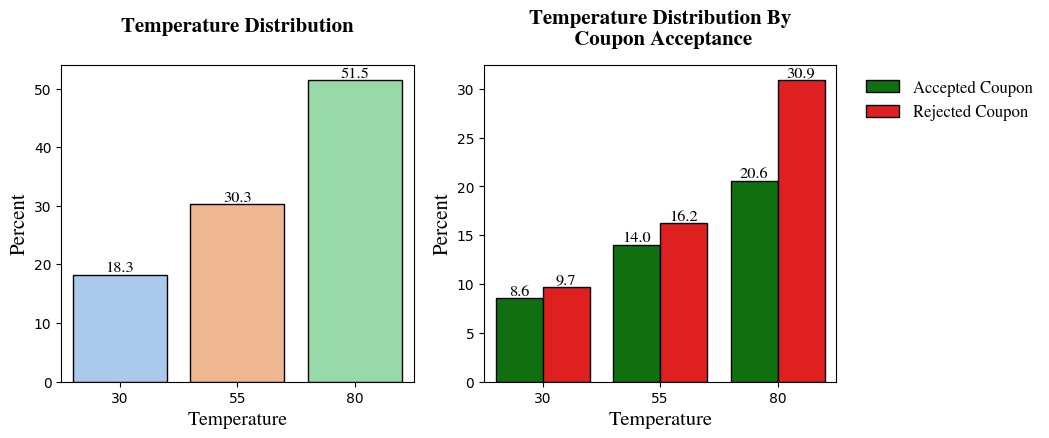

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("temperature", axes[0])
subplot_distribution_by_coupon_acceptance("temperature", axes[1])
fig.show()

**Figure Takeways**
*  Temperature is right skewed as there are more data points with higher temperatures.
*  Temperature is also discrete with only 3 possible values: 30, 55, and 80.

###### Passenger Distribution <a name="7"></a>

We rename `'passanger'` to `'passenger'`

In [9]:
data = data.rename(columns={'passanger':'passenger'})

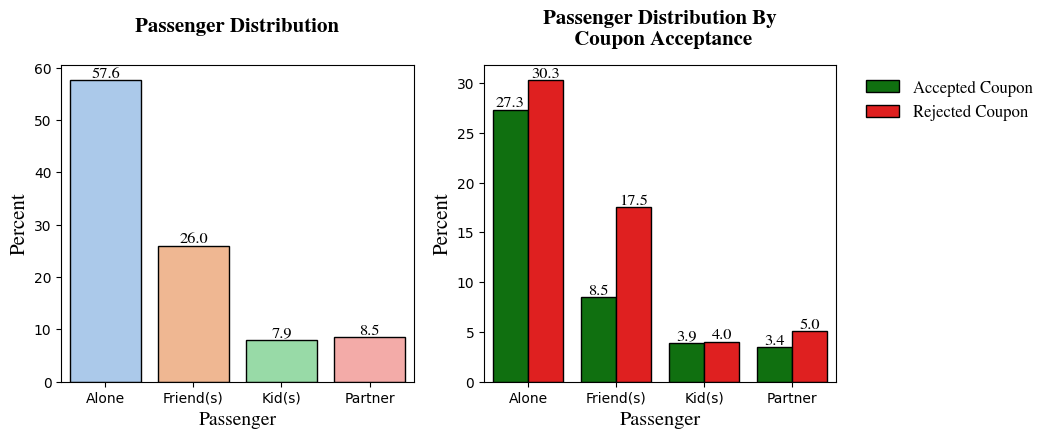

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("passenger", axes[0])
subplot_distribution_by_coupon_acceptance("passenger", axes[1])
fig.show()

**Figure Takeways**
*  Over half of the data points are with no passengers, or Alone. The second highest is under 30% are with Friend(s) as passengers.

###### Weather Distribution <a name="8"></a>

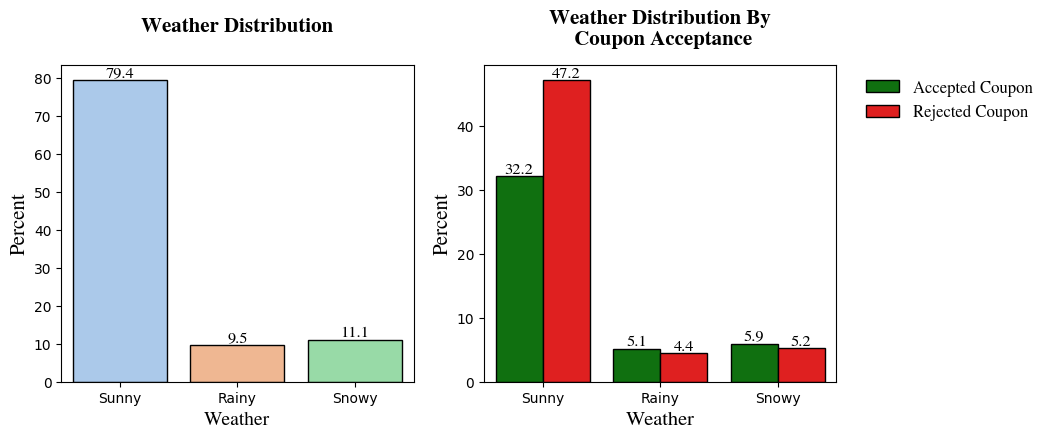

In [11]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("weather", axes[0])
subplot_distribution_by_coupon_acceptance("weather", axes[1])
fig.show()

**Figure Takeways**
*  Almost 80% of the data points are with Sunny weather.

###### Destination Distribution <a name="9"></a>

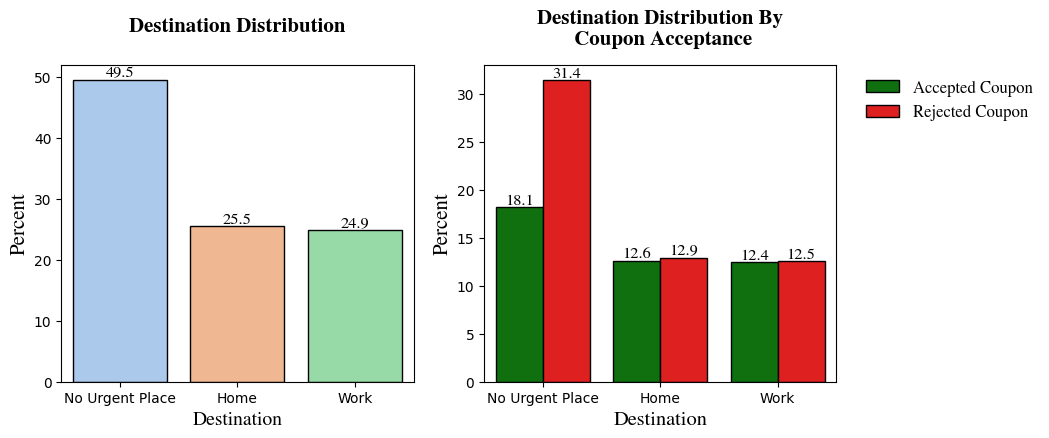

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("destination", axes[0])
subplot_distribution_by_coupon_acceptance("destination", axes[1])
fig.show()

**Figure Takeways**
*  Half of the data points have No Urgent Place as their destination. Around 25% have Home as the destination, and the remaining 25% with Work.

###### Time Distribution <a name="10"></a>

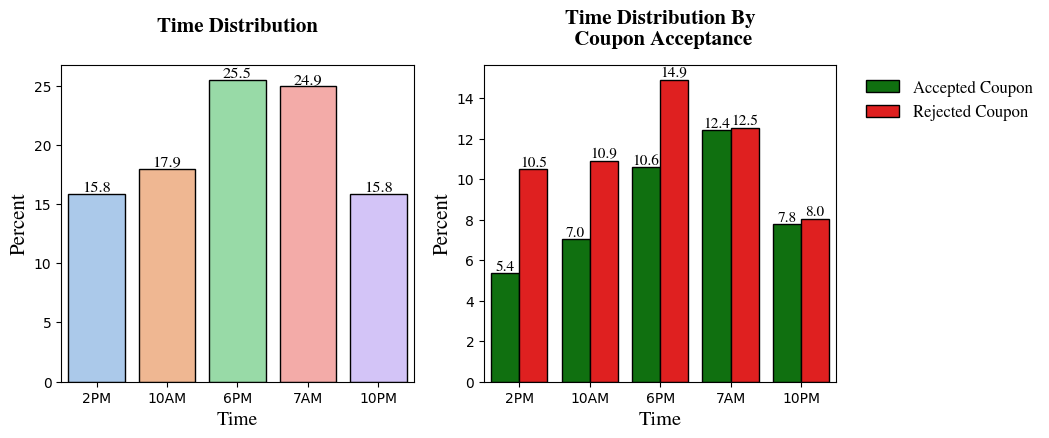

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("time", axes[0])
subplot_distribution_by_coupon_acceptance("time", axes[1], add_labels=False)
# fix overlapping text with smaller font
for i in range(len(axes[1].containers)):
  axes[1].bar_label(axes[1].containers[i], fmt="{:.1f}",fontsize=11, color="black", padding=0, fontname='STIXGeneral')
fig.show()

**Figure Takeways**
*  There are a spread out percentage of data points across 5 timepoints with slightly more at 6PM and 7AM.
*  There are a discrete number of times.

###### Expiration Distribution <a name="11"></a>

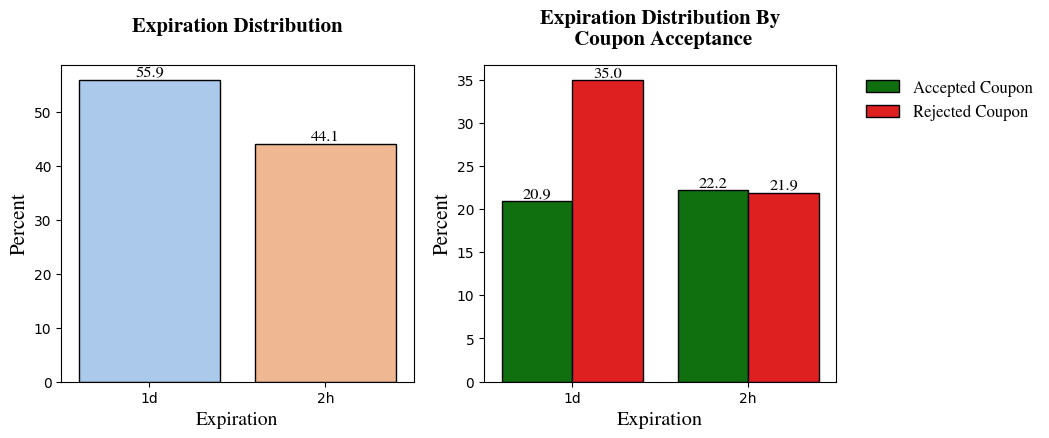

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("expiration", axes[0])
subplot_distribution_by_coupon_acceptance("expiration", axes[1])
fig.show()

**Figure Takeways**
*  Around same percentage expire in 1 day or in 2 hours.

###### Gender Distribution <a name="12"></a>

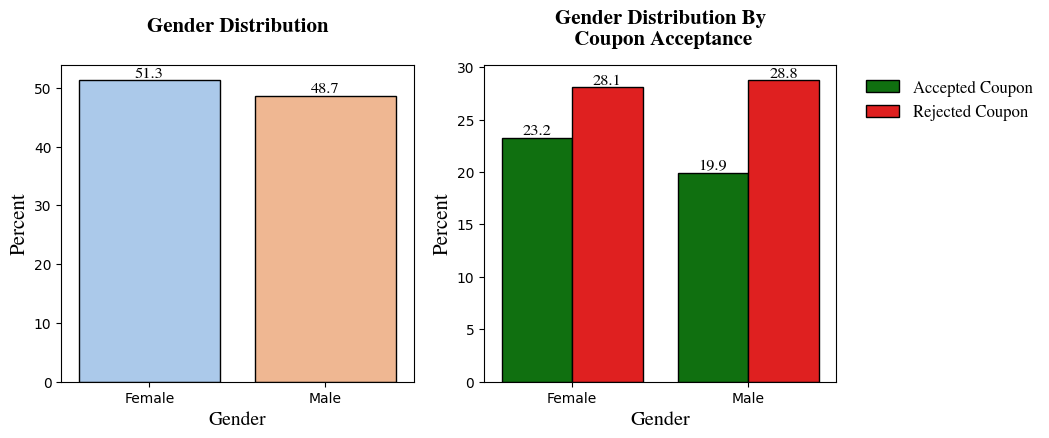

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("gender", axes[0])
subplot_distribution_by_coupon_acceptance("gender", axes[1])
fig.show()

**Figure Takeways**
*  Around same percentage of both females and males.

###### Age Distribution <a name="13"></a>

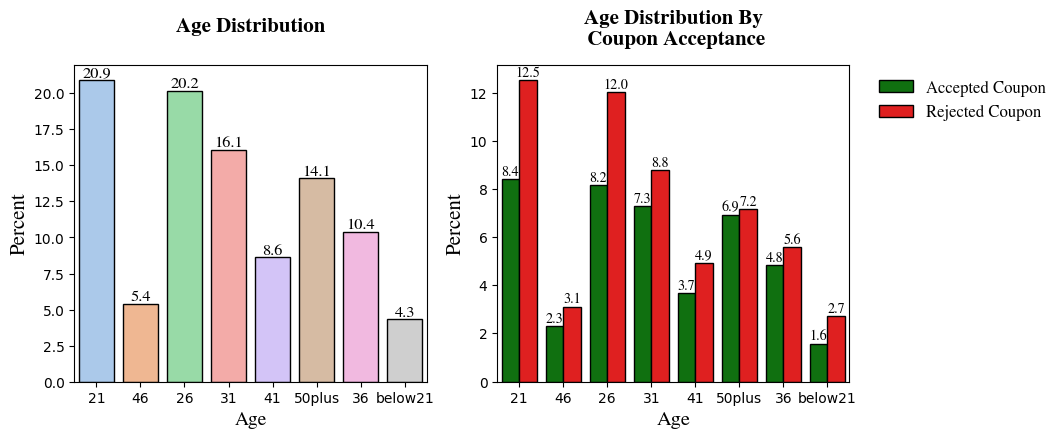

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("age", axes[0])
subplot_distribution_by_coupon_acceptance("age", axes[1],add_labels=False)
# fix overlapping text with smaller font
for i in range(len(axes[1].containers)):
  axes[1].bar_label(axes[1].containers[i], fmt="{:.1f}",fontsize=10.1, color="black", padding=0.5, fontname='STIXGeneral')
fig.show()

**Figure Takeways**
*  Most of the people are 21, 26, 31, 31, 36, and 50plus. The smallest percentage of people are 41, 46, and below 21.

###### Marital Status Distribution <a name="14"></a>

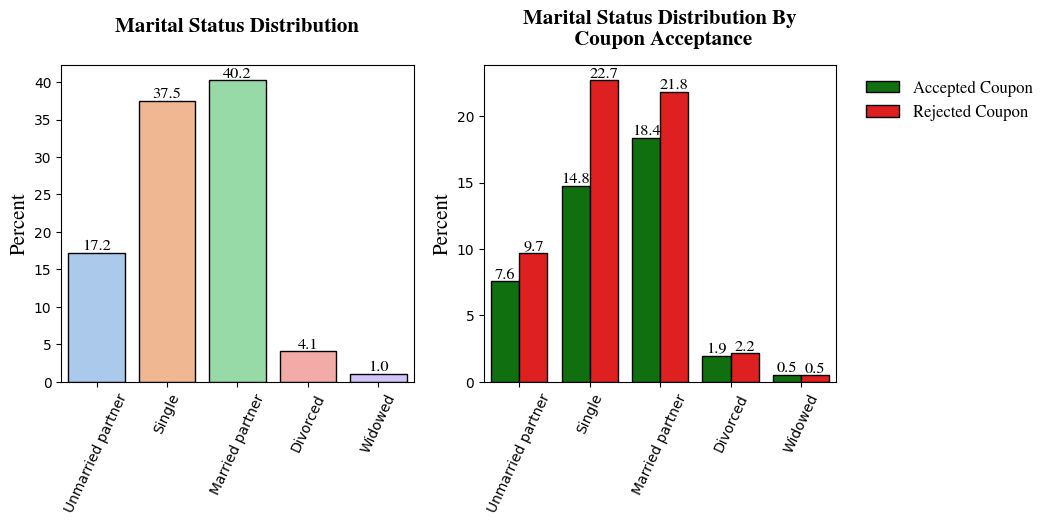

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("maritalStatus", axes[0])
subplot_distribution_by_coupon_acceptance("maritalStatus", axes[1])
# fix overlapping x axis labels
axes[0].tick_params(axis='x', which='both', colors='black', labelrotation=65)
axes[1].tick_params(axis='x', which='both', colors='black', labelrotation=65)
# update title and subtitles
axes[0].set_title(label="Marital Status Distribution", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=24)
axes[1].set_title(label="Marital Status Distribution By\n Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[0].set_xlabel("")
axes[1].set_xlabel("")
fig.show()

**Figure Takeways**
*  Over 70% of the data points are either Single or have a Married partner.

###### Has Children Distribution <a name="15"></a>

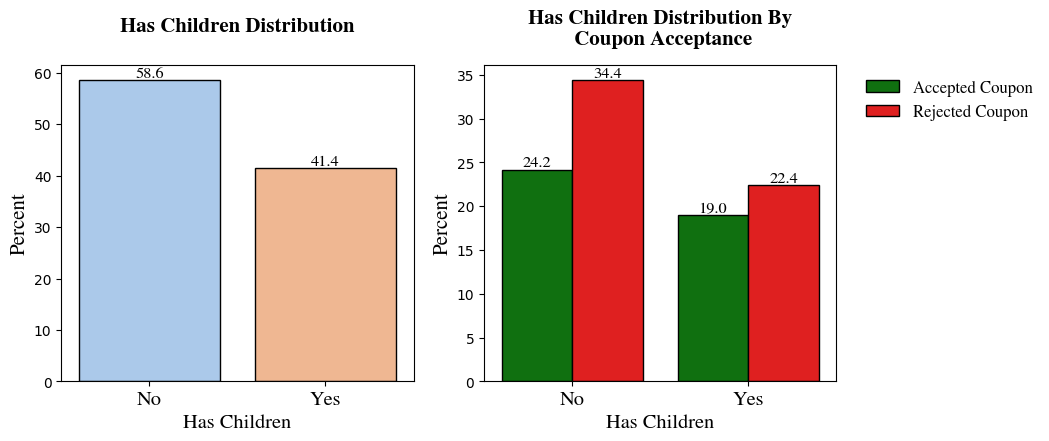

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("has_children", axes[0])
subplot_distribution_by_coupon_acceptance("has_children", axes[1])
# update title, ticks, subtitles
axes[0].set_title(label="Has Children Distribution", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=24)
axes[1].set_title(label="Has Children Distribution By\n Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="Has Children", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Has Children", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)

fig.show()

**Figure Takeways**
*  Slightly higher percentage of people without children.

###### Education Distribution <a name="16"></a>

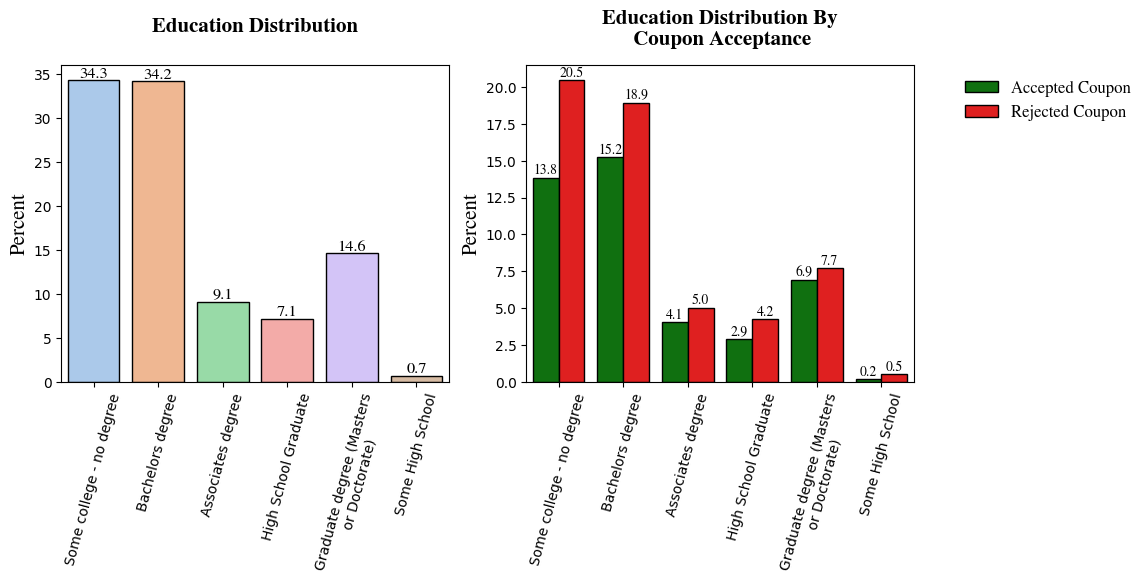

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
subplot_overall_distribution("education", axes[0])
subplot_distribution_by_coupon_acceptance("education", axes[1], add_labels=False)
# fix overlapping text with smaller font
for i in range(len(axes[1].containers)):
  axes[1].bar_label(axes[1].containers[i], fmt="{:.1f}",fontsize=9.8, color="black", padding=0.5, fontname='STIXGeneral')
# fix overlapping x axis labels
axes[0].tick_params(axis='x', which='both', colors='black', labelrotation=75)
axes[1].tick_params(axis='x', which='both', colors='black', labelrotation=75)
axes[0].set_xlabel("")
axes[1].set_xlabel("")
# update long label to go on next line
curr_xlabels = axes[0].get_xticklabels()
curr_xlabels[4] = 'Graduate degree (Masters\n or Doctorate)'
axes[0].set_xticks(range(6))
axes[0].set_xticklabels(curr_xlabels)
curr_xlabels = axes[1].get_xticklabels()
curr_xlabels[4] = 'Graduate degree (Masters\n or Doctorate)'
axes[1].set_xticks(range(6))
axes[1].set_xticklabels(curr_xlabels)
fig.show()

**Figure Takeways**
*  Over half of the data points have either Some college - no degree or Bachelors. The smallest is Some High School.

###### Occupation Distribution <a name="17"></a>

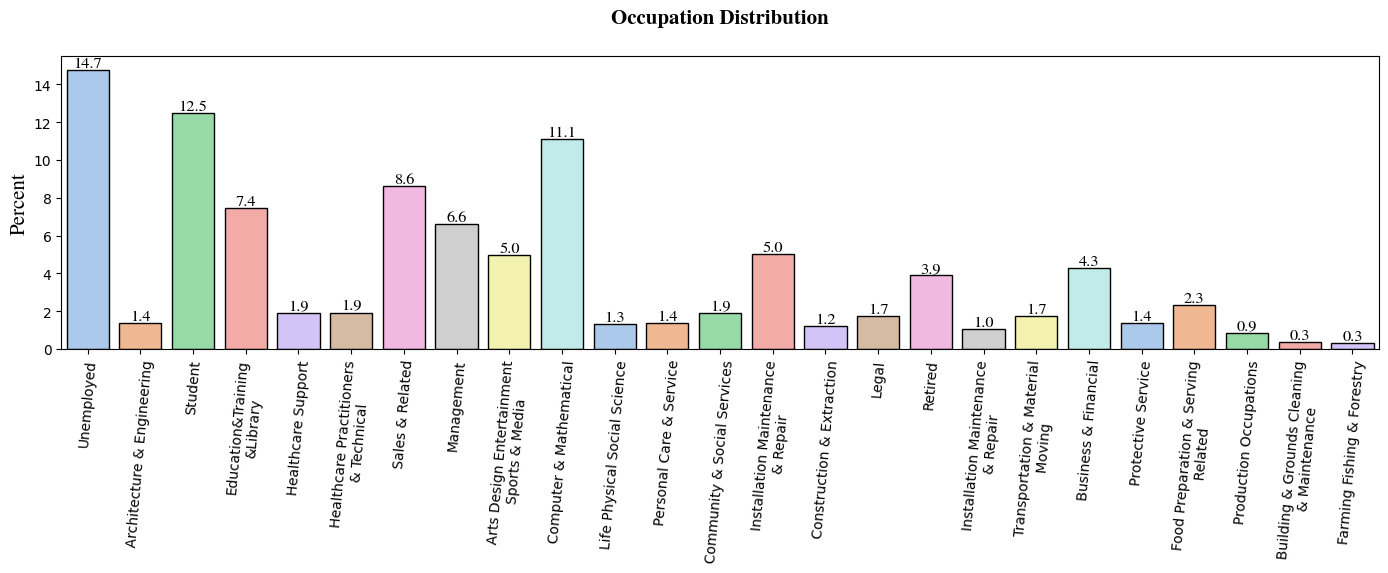

In [ ]:
# Occupation has a lot of categories, so created 2 separate plots
fig1, ax1 = plt.subplots(figsize=(17,3.8))
subplot_overall_distribution("occupation", ax1)
plt.xticks(rotation=85)
plt.xlabel("")
# Update long labels to go on next line
curr_xlabels = ax1.get_xticklabels()
curr_xlabels[3] = 'Education&Training\n&Library'
curr_xlabels[5] = 'Healthcare Practitioners\n & Technical'
curr_xlabels[8] = 'Arts Design Entertainment\n Sports & Media'
curr_xlabels[13] = 'Installation Maintenance\n & Repair'
curr_xlabels[17] = 'Installation Maintenance\n & Repair'
curr_xlabels[18] = 'Transportation & Material\n Moving'
curr_xlabels[21] = 'Food Preparation & Serving\n Related'
curr_xlabels[23] =  'Building & Grounds Cleaning\n & Maintenance'
ax1.set_xticks(range(25))
ax1.set_xticklabels(curr_xlabels)
fig1.show()

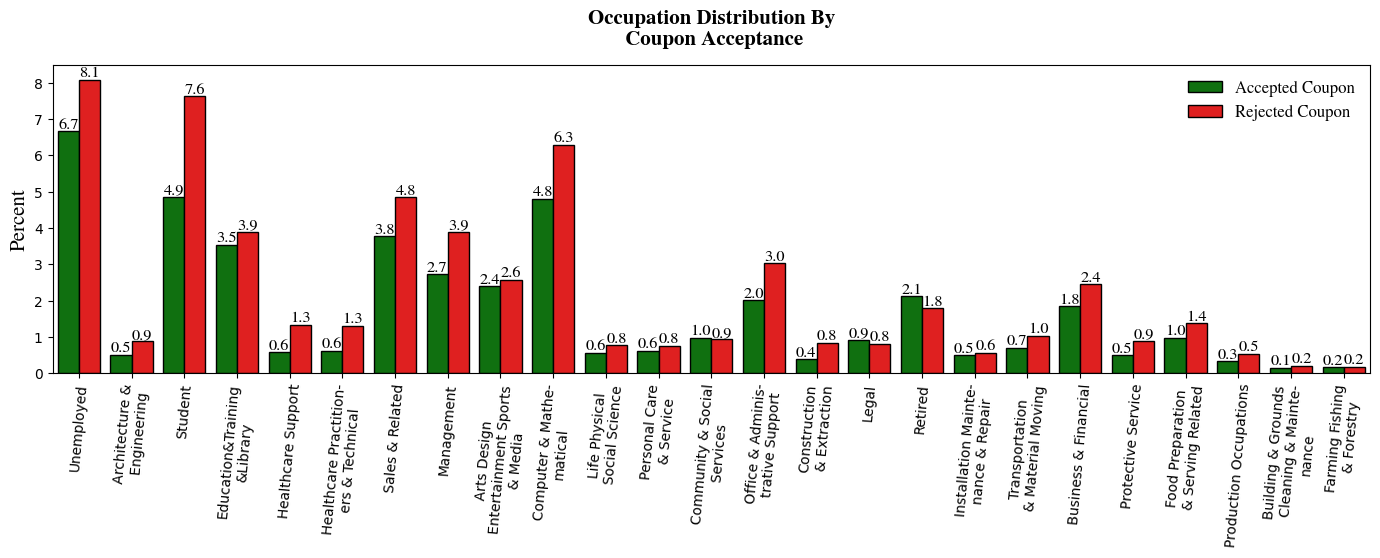

In [ ]:
fig2, ax2 = plt.subplots(figsize=(17,4))
# Create plot, add customizations to data bar labels, x & y labels, and tick labels
var = "occupation"
ax = ax2
add_labels=True
sns.countplot(ax=ax, data=data,x=var, hue="Y", palette=["g", "r"], stat="percent", edgecolor="black", legend=False)
if add_labels:
  for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i], fmt="{:.1f}",fontsize=11.75, color="black", padding=0, fontname='STIXGeneral')
plt.legend(labels=["Accepted Coupon", "Rejected Coupon"],frameon=False, prop=dict(family='STIXGeneral', size=12))
ax.set_title(label=var.capitalize() +  " Distribution By\n Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel=var.capitalize(), fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Percent", fontdict=dict(fontsize=15,color='black', fontname='STIXGeneral'), labelpad=3)
ax.tick_params(axis='x', which='both', colors='black', labelsize=10)
ax.tick_params(axis='y', which='both', colors='black', labelsize=10)

plt.xticks(rotation=85)
plt.xlabel("")

# Update long labels to go on next line
curr_xlabels = ax2.get_xticklabels()

curr_xlabels[1] = 'Architecture &\n Engineering'
curr_xlabels[3] = 'Education&Training\n&Library'
curr_xlabels[5] = 'Healthcare Practition-\ners & Technical'
curr_xlabels[8] = 'Arts Design\n Entertainment Sports\n & Media'
curr_xlabels[9] = 'Computer & Mathe-\nmatical'
curr_xlabels[10] = 'Life Physical\n Social Science'
curr_xlabels[11] = 'Personal Care\n & Service'
curr_xlabels[12] =  'Community & Social\n Services'
curr_xlabels[13] = 'Office & Adminis-\ntrative Support'
curr_xlabels[14] = 'Construction\n & Extraction'
curr_xlabels[17] = 'Installation Mainte-\nnance & Repair'
curr_xlabels[18] = 'Transportation \n& Material Moving'
curr_xlabels[21] = 'Food Preparation\n & Serving Related'
curr_xlabels[23] =  'Building & Grounds\n Cleaning & Mainte-\nnance'
curr_xlabels[24] = 'Farming Fishing\n & Forestry'
ax2.set_xticks(range(25))
ax2.set_xticklabels(curr_xlabels)
fig2.show()

**Figure Takeways**
*  Unemployed, Student, Computer & Mathematical, and Sales & Related are the first four highest occupations. There are 25 occupation categories.

###### Income Distribution <a name="18"></a>


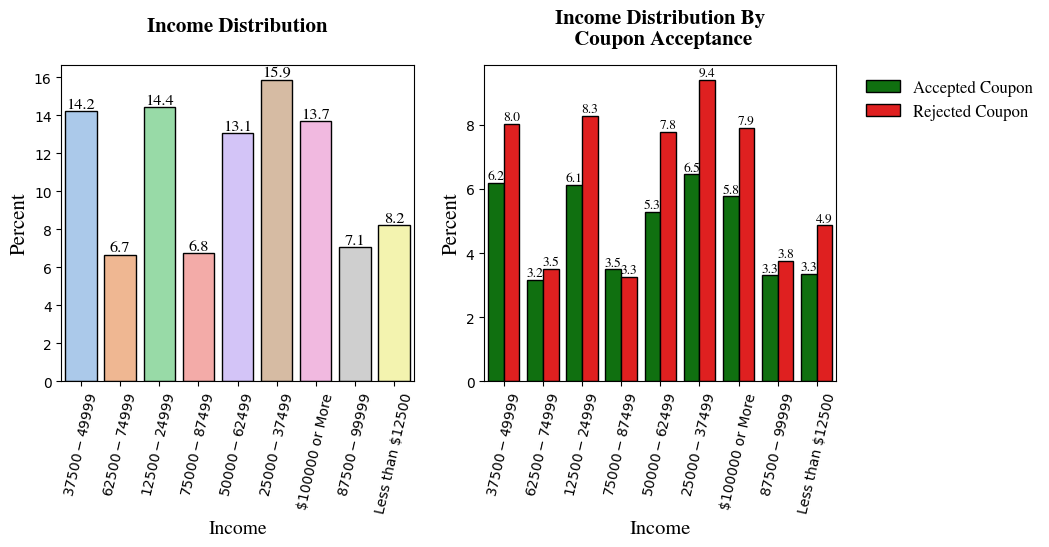

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("income", axes[0])
subplot_distribution_by_coupon_acceptance("income", axes[1],add_labels=False)
# fix overlapping x axis labels
axes[0].tick_params(axis='x', which='both', colors='black', labelrotation=77)
axes[1].tick_params(axis='x', which='both', colors='black', labelrotation=77)
# fix overlapping text with smaller font
for i in range(len(axes[1].containers)):
  axes[1].bar_label(axes[1].containers[i], fmt="{:.1f}",fontsize=9.7, color="black", padding=0.5, fontname='STIXGeneral')
fig.show()

**Figure Takeways**
*  Income is well distributed across several 9 income brackets.

###### Bar Distribution <a name="19"></a>

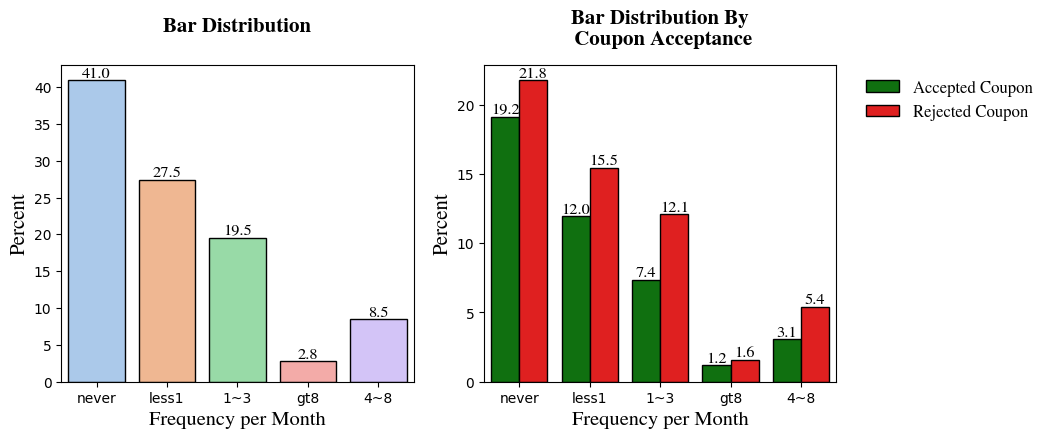

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("Bar", axes[0])
subplot_distribution_by_coupon_acceptance("Bar", axes[1])
axes[0].set_xlabel(xlabel="Frequency per Month", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Frequency per Month", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.show()

**Figure Takeways**
*  About 40% never go to bar, around 30% go once per month, and 20% go 1-3 times per month
*  Around only 10% of people go to bar over 4 times per month.

###### CoffeeHouse Distribution <a name="20"></a>

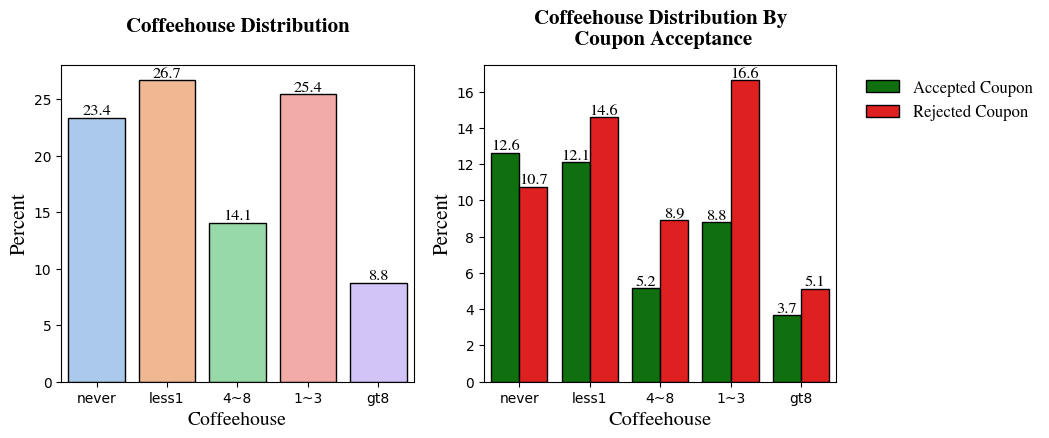

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("CoffeeHouse", axes[0])
subplot_distribution_by_coupon_acceptance("CoffeeHouse", axes[1])
fig.show()

**Figure Takeways**
*  Around 80% of people go never, less than once, or 1-3 times to the coffee house. Around 20% go over 4 times per month.

###### CarryAway Distribution <a name="21"></a>

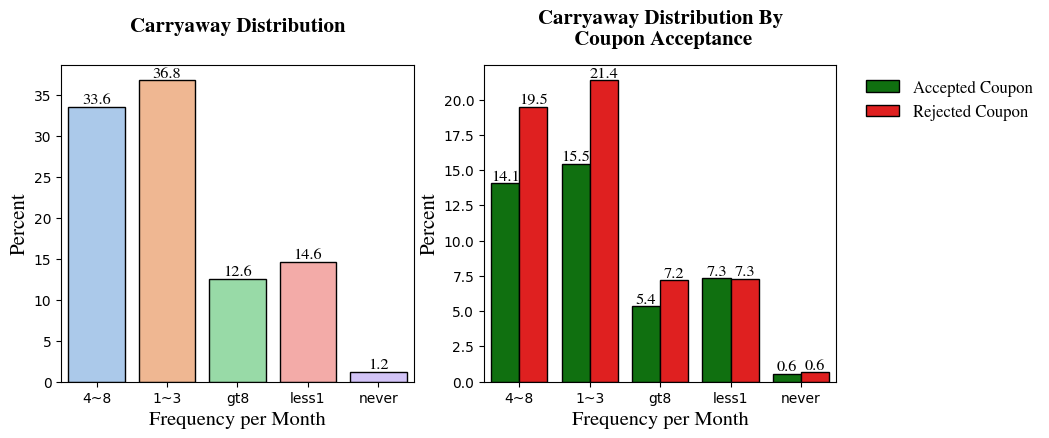

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("CarryAway", axes[0])
subplot_distribution_by_coupon_acceptance("CarryAway", axes[1])
axes[0].set_xlabel(xlabel="Frequency per Month", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Frequency per Month", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.show()

**Figure Takeways**
*  Around 70% either use CarryAway 4-8 times or 1-3 times per month. Very small percentage never uses CarryAway.

###### RestaurantLessThan20 Distribution <a name="22"></a>

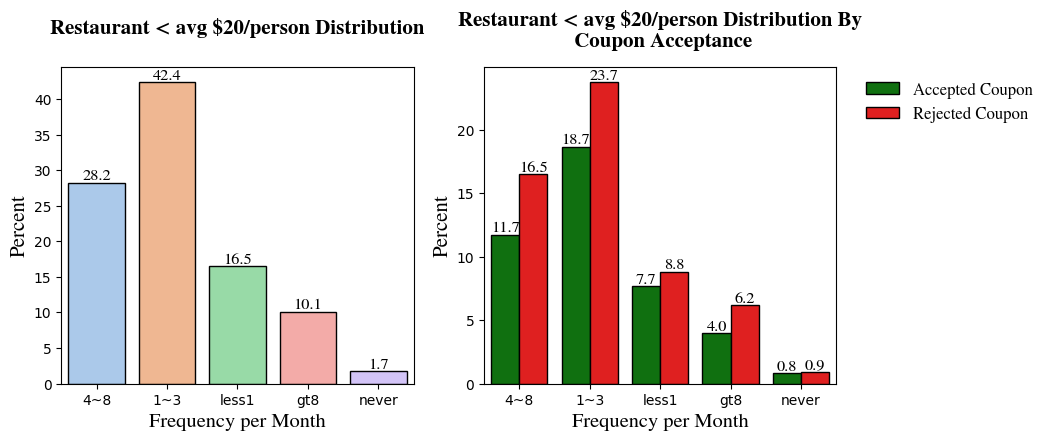

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("RestaurantLessThan20", axes[0])
subplot_distribution_by_coupon_acceptance("RestaurantLessThan20", axes[1])
# update title, subtitles
axes[0].set_title(label="Restaurant < avg $20/person Distribution", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=24)
axes[1].set_title(label="Restaurant < avg $20/person Distribution By\n Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[0].set_xlabel(xlabel="Frequency per Month", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Frequency per Month", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.show()

**Figure Takeways**
*  Around 70% of people go less than once or 1-3 times to these cheaper restaurants.

###### Restaurant20To50 Distribution <a name="23"></a>


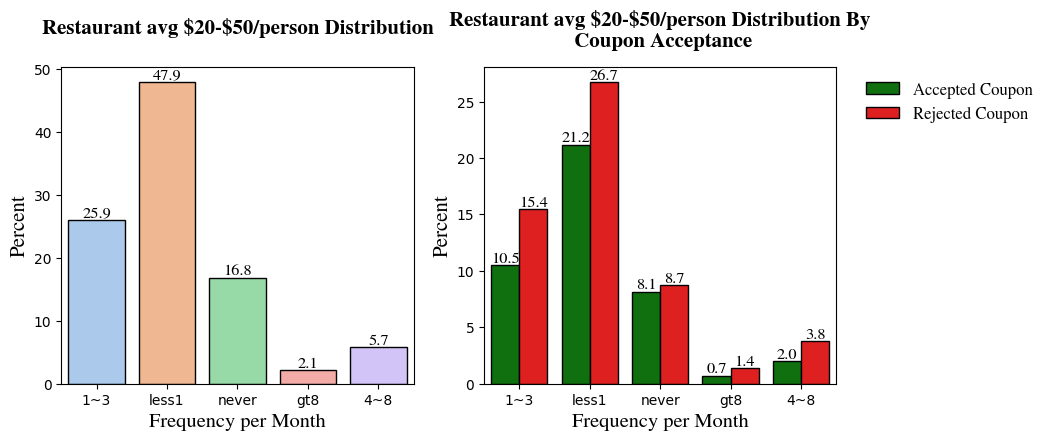

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("Restaurant20To50", axes[0])
subplot_distribution_by_coupon_acceptance("Restaurant20To50", axes[1])
# update title, subtitles
axes[0].set_title(label="Restaurant avg \$20-\$50/person Distribution", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=24)
axes[1].set_title(label="Restaurant avg \$20-\$50/person Distribution By\n Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[0].set_xlabel(xlabel="Frequency per Month", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Frequency per Month", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.show()

**Figure Takeways**
*  Around 50% of people go less than once per month to these more expensive restaurants. 25% go 1-3 times per month to these more expensive restaurants.


###### toCoupon_GEQ5min Distribution <a name="24"></a>

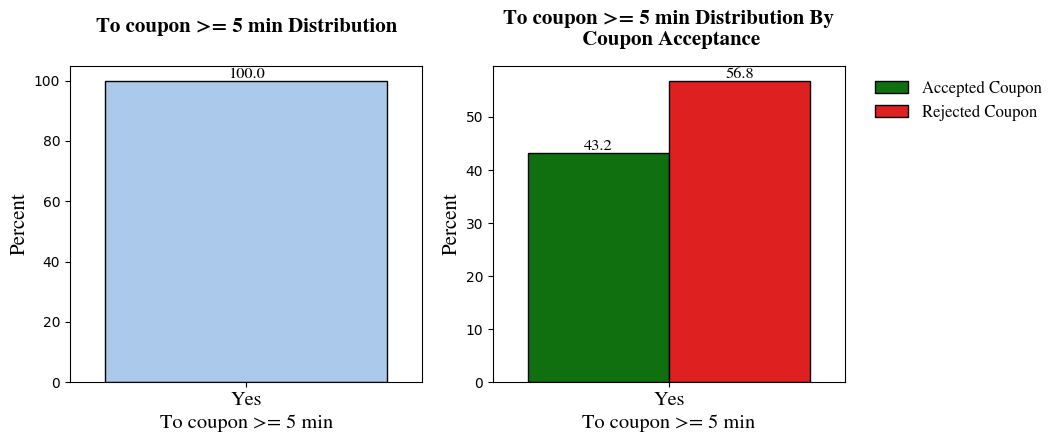

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("toCoupon_GEQ5min", axes[0])
subplot_distribution_by_coupon_acceptance("toCoupon_GEQ5min", axes[1])
# update title, subtitles, xticks labels
axes[0].set_title(label="To coupon >= 5 min Distribution", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=24)
axes[1].set_title(label="To coupon >= 5 min Distribution By\n Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[0].set_xticks([0])
axes[1].set_xticks([0])
axes[0].set_xticklabels(["Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="To coupon >= 5 min", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="To coupon >= 5 min", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.show()

**Figure Takeways**
*  All coupons are for locations that are greater than or equal to 5 minutes from the customer's location. Therefore, this column does not tell us anything and can be be dropped.

###### toCoupon_GEQ15min Distribution <a name="25"></a>

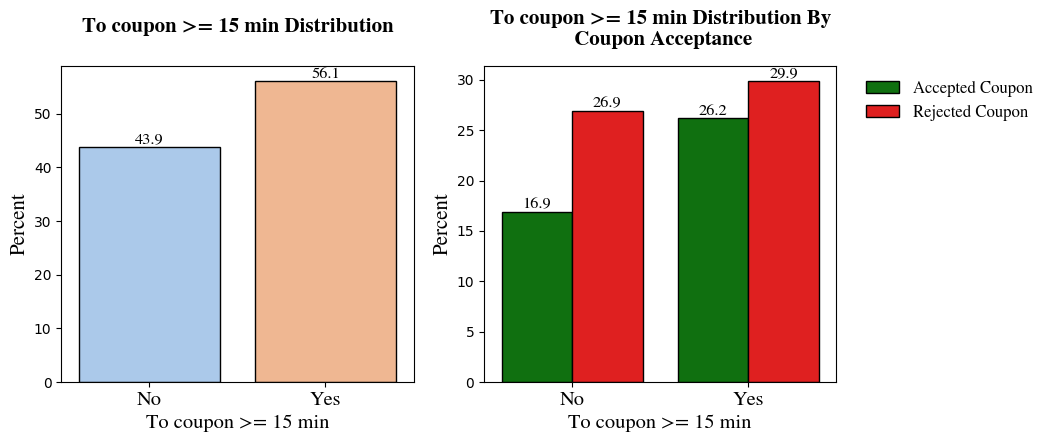

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("toCoupon_GEQ15min", axes[0])
subplot_distribution_by_coupon_acceptance("toCoupon_GEQ15min", axes[1])
# update title, subtitles, xticks labels
axes[0].set_title(label="To coupon >= 15 min Distribution", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=24)
axes[1].set_title(label="To coupon >= 15 min Distribution By\n Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="To coupon >= 15 min", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="To coupon >= 15 min", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.show()

**Figure Takeways**
*  Slightly more coupons for locations greater than or equal to 15 minutes.

###### toCoupon_GEQ25min Distribution <a name="26"></a>

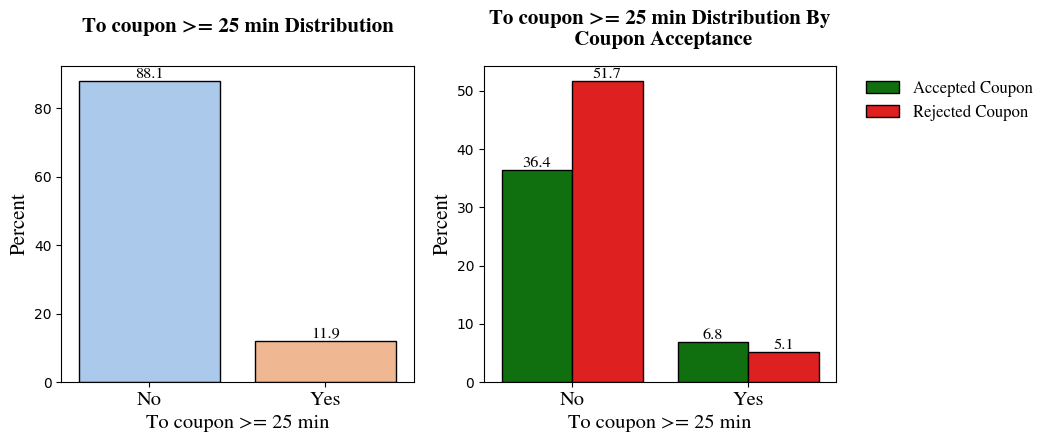

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("toCoupon_GEQ25min", axes[0])
subplot_distribution_by_coupon_acceptance("toCoupon_GEQ25min", axes[1])
# update title, subtitles, xticks labels
axes[0].set_title(label="To coupon >= 25 min Distribution", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=24)
axes[1].set_title(label="To coupon >= 25 min Distribution By\n Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="To coupon >= 25 min", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="To coupon >= 25 min", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.show()

**Figure Takeways**
*  Almost 90% of coupons are not for locations >= 25 minutes away.

###### direction_same Distribution <a name="27"></a>

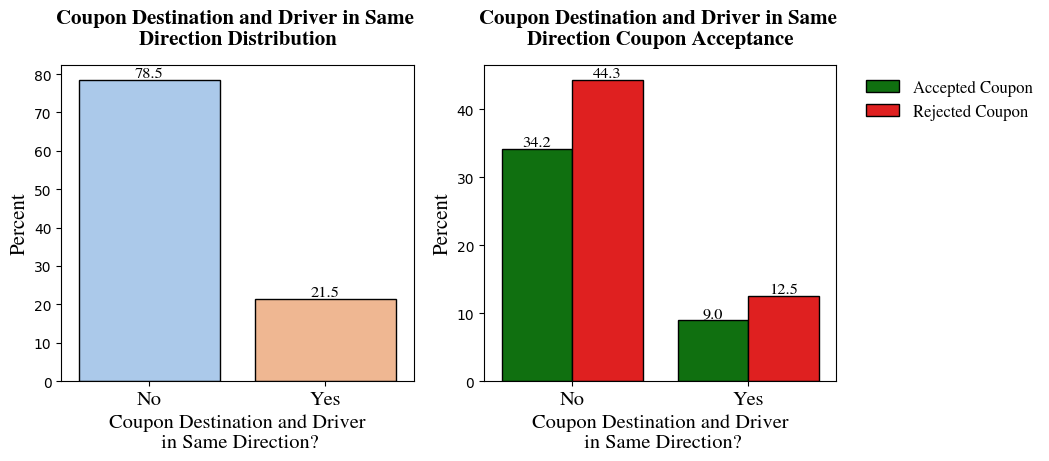

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("direction_same", axes[0])
subplot_distribution_by_coupon_acceptance("direction_same", axes[1])
# update title, subtitles, xticks labels
axes[0].set_title(label="Coupon Destination and Driver in Same \nDirection Distribution", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[1].set_title(label="Coupon Destination and Driver in Same \nDirection Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="Coupon Destination and Driver\n in Same Direction?", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Coupon Destination and Driver\n in Same Direction?", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.show()

**Figure Takeways**
*  Almost 80% of the time coupon destination and driver are not in same direction.

###### direction_opp Distribution <a name="28"></a>

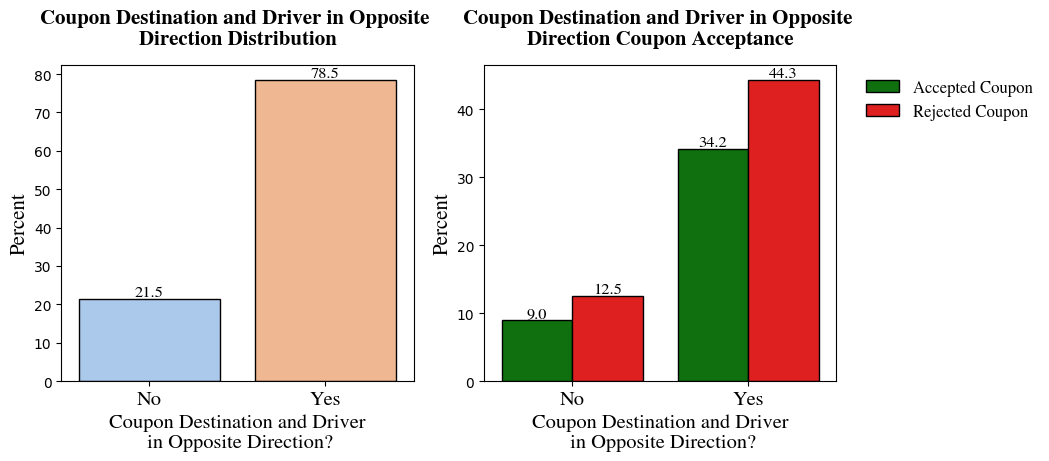

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,4.11))
subplot_overall_distribution("direction_opp", axes[0])
subplot_distribution_by_coupon_acceptance("direction_opp", axes[1])
# update title, subtitles, xticks labels
axes[0].set_title(label="Coupon Destination and Driver in Opposite \nDirection Distribution", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[1].set_title(label="Coupon Destination and Driver in Opposite \nDirection Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="Coupon Destination and Driver\n in Opposite Direction?", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Coupon Destination and Driver\n in Opposite Direction?", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.show()

**Figure Takeways**
*  Almost 80% of the time coupon destination and driver are in opposite direction.

##### 3. Decide what to do about your missing data -- drop, replace, other... <a name="29"></a>

*   List item
*   List item



*   We drop car column because 99% of the values in the car column are null.
*   We will replace all other null values in columns since they have less than 2% of values null in their respective columns. Since we are handling categorical data, we will replace with mode.
*   We will also drop the toCoupon_GEQ5min, since it is 1 for every data point and does not give us any useful information.



In [ ]:
data = data.drop(columns=["car", "toCoupon_GEQ5min"])

In [ ]:
values = {"CoffeeHouse": data["CoffeeHouse"].mode()[0], "Restaurant20To50": data["Restaurant20To50"].mode()[0], "CarryAway":  data["CarryAway"].mode()[0], "RestaurantLessThan20": data["RestaurantLessThan20"].mode()[0], "Bar": data["Bar"].mode()[0]}
data = data.fillna(value=values)

##### 4. What proportion of the total observations chose to accept the coupon <a name="30"></a>



In [18]:
## Helper method
# Calculate coupon response percents for piechart
def get_coupon_response_percents(data):
  coupon_response = data[["Y"]]
  coupon_response = coupon_response.astype(str)
  coupon_response.loc[coupon_response["Y"] == '0', :] = "Accept"
  coupon_response.loc[coupon_response["Y"] == '1', :] = "Reject"
  coupon_response_percent = coupon_response["Y"].value_counts(normalize=True).sort_values().round(2)*100
  coupon_response_percent = coupon_response_percent.astype(int)
  coupon_response_percent = coupon_response_percent.astype(str)
  coupon_response_percent = coupon_response_percent + "%"
  coupon_response = coupon_response["Y"].value_counts().sort_values()
  return coupon_response, coupon_response_percent

In [19]:
## Helper method
# Create piechart for coupon acceptance
def accept_coupon_piechart(curr_data, title, colors, reverse=False):
  coupon_response, coupon_response_percent = get_coupon_response_percents(curr_data)
  values = coupon_response.tolist()
  labels = coupon_response.index.tolist()
  percent_labels = [coupon_response_percent.index[0] + "\n " +  coupon_response_percent.iloc[0], coupon_response_percent.index[1] + "\n " +  coupon_response_percent.iloc[1]]

  plt.figure(figsize=(3.5, 3.5))
  explode=[0.025, 0.025]
  plt.pie(values, labels=percent_labels, colors=colors, textprops=dict(color='white', fontsize=15, fontweight="bold", horizontalalignment='center'),labeldistance=0.5, explode=explode)
  plt.title(title, fontdict=dict(fontsize=20,fontweight='bold',color='black',fontname='STIXGeneral'), pad=45, x=0.57, y=0.825)
  plt.legend(labels=labels, bbox_to_anchor=(1.5, 0.7), loc="right", prop=dict(family='STIXGeneral', size=15), frameon=False, reverse=reverse) #,   , fontsize='large'
  return plt

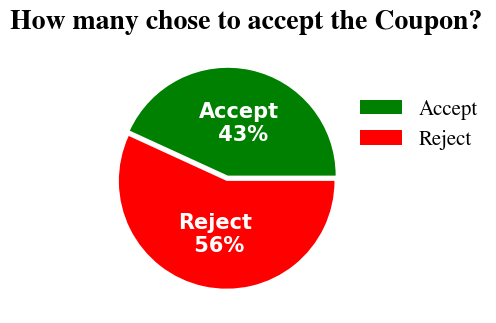

In [20]:
accept_coupon_piechart(data, "How many chose to accept the Coupon?", ['g', 'r']).show()

**Figure Takeway:**
43% of observations accept the coupon.



##### 5. Use a bar plot to visualize the `coupon` column.  <a name="31"></a>

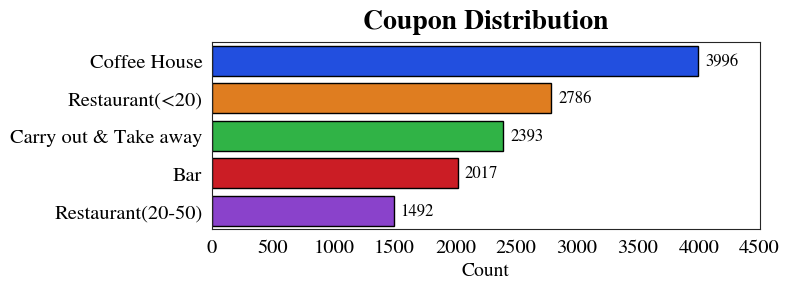

In [ ]:
plt.figure(figsize=(8, 3))
sns.set_style("white")

coupon_counts = data[["coupon"]].value_counts().reset_index()

ax = sns.barplot(coupon_counts, y="coupon", x="count", hue="coupon", palette="bright", edgecolor='black')

# add data labels
for i in range(len(ax.containers)):
  ax.bar_label(ax.containers[i], fontsize=12, color="black", padding=5, fontname='STIXGeneral')

# formatting labels
ax.set_title(label="Coupon" +  " Distribution", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
ax.set_xlabel(xlabel="Count", fontdict=dict(fontsize=14,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="", fontdict=dict(fontsize=15,color='black', fontname='STIXGeneral'), labelpad=3)
ax.tick_params(axis='x', which='both', colors='black', labelsize=10)
ax.tick_params(axis='y', which='both', colors='black', labelsize=10)
ax.set_xlim(0, 4500)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')


plt.tight_layout()
plt.show()

##### 6. Use a histogram to visualize the temperature column. <a name="32"></a>

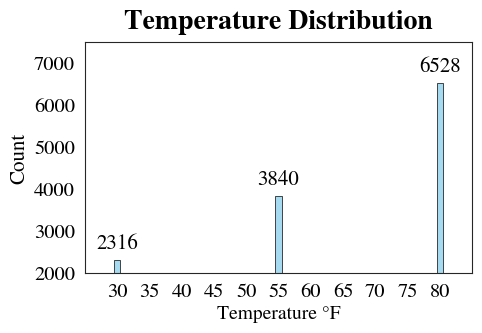

In [ ]:
sns.set_style("white")
plt.figure(figsize=(5, 3))
ax = sns.histplot(data, x="temperature", color="skyblue", edgecolor='black', discrete=True)

# add data labels
for i in range(len(ax.containers)):
  ax.bar_label(ax.containers[i], fontsize=15, color="black", padding=5, fontname='STIXGeneral')

# formatting labels
ax.set_title(label="Temperature Distribution", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
ax.set_xlabel(xlabel="Temperature °F", fontdict=dict(fontsize=14,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Count", fontdict=dict(fontsize=15,color='black', fontname='STIXGeneral'), labelpad=3)
ax.tick_params(axis='x', which='both', colors='black', labelsize=10)
ax.tick_params(axis='y', which='both', colors='black', labelsize=10)
ax.set_xlim(0, 4500)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(np.arange(30, 85, step=5), fontsize=14.65,color='black', fontname='STIXGeneral')
plt.ylim(2000, 7500)
plt.xlim(25, 85)

plt.show()

##### **Investigating the Bar Coupons**   <a name="33"></a>

Now, we will lead you through an exploration of just the bar related coupons.  

1. Create a new `DataFrame` that contains just the bar coupons.


In [16]:
bar_coupons = data.loc[data["coupon"]=='Bar', :]
bar_coupons.shape

(2017, 26)

##### 2. What proportion of bar coupons were accepted? <a name="34"></a>


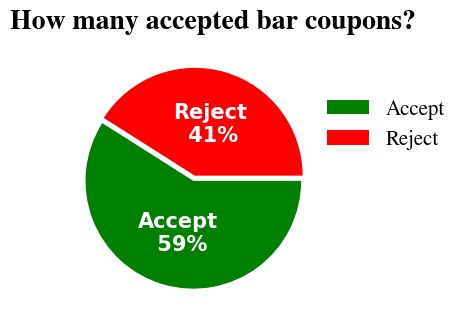

In [21]:
accept_coupon_piechart(bar_coupons, "How many accepted bar coupons?", ['r', 'g'], reverse=True).show()

**Figure Takeways**
59% of bar coupons were accepted.

##### 3. Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more.  <a name="35"></a>



In [ ]:
sns.set_style("whitegrid")

In [55]:
## Helper method
# Calculates acceptance rate and count
def calculate_acceptance_rate(data):
  rate = data[["Y"]].value_counts(normalize=True).reset_index()
  count = data[["Y"]].value_counts().reset_index().loc[rate["Y"] == 1, :]["count"]
  return rate.loc[rate["Y"] == 1, :]["proportion"], count.iloc[0], len( data[["Y"]])

## Helper method
# Formats acceptance rate for bar chart
def format_acceptance_rate(data0, data1, name0, name1, count0, count1, total0, total1):
  data = [round(float(data0.iloc[0]),2)*100, round(float(data1.iloc[0]),2)*100]
  counts, names, totals = [count0, count1], [name0, name1], [total0, total1]
  text = [str(int(data[i])) + "% (" + str(counts[i]) + "/" +  str(totals[i]) + ")" for i in range(2)]
  title = "<b>Bar Coupon Acceptance Rate</b>"
  if int(data[1]-data[0]) > 0:
    diff_text = "Δ = +" + str(int(data[1]-data[0])) + "%"
  else:
    diff_text = "Δ = " + str(int(data[1]-data[0])) + "%"
  return data, names, text, title, diff_text

In [56]:
## Helper method
# Creates bar graph with formatting
def compare_acceptance_rate_graph(bar_data, names, text, title, diff_text, colors, order, add_delta=True, positive_delta=True):
  fig, ax = plt.subplots(figsize=(7, 2.25))
  sns.barplot(ax=ax, x = bar_data, y = names, hue = names, order=order, palette=colors)
  # add data labels
  i=0
  for container in ax.containers:
      ax.bar_label(container, fmt=text[i], label_type='center', fontsize=15, color="white", padding=1.5, fontweight="bold")
      i+=1
  # formatting labels
  ax.set_title(label="Bar Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  ax.set_xlabel(xlabel="Percent", fontdict=dict(fontsize=14,color='black', fontname='STIXGeneral'), labelpad=4)
  ax.set_ylabel(ylabel="", fontdict=dict(fontsize=15,color='black', fontname='STIXGeneral'), labelpad=3)
  ax.tick_params(axis='x', which='both', colors='black', labelsize=10)
  ax.tick_params(axis='y', which='both', colors='black', labelsize=10)
  plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
  plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
  if add_delta:
    if positive_delta:
      ax.text(x=68, y=1.15, s=diff_text, fontsize=22, color='r', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
    else:
      ax.text(x=60, y=0.2, s=diff_text, fontsize=22, color='r', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
  return fig, ax

In [57]:
## Helper method
# Calls all above methods to create acceptance rate bar graph based on two condition arguments
def make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, positive_delta=True, add_delta=True):
  data0 = curr_data.loc[condition0]
  data1 = curr_data.loc[condition1]
  order = [text_condition1, text_condition0]

  acceptance_rate_data0, acceptance_count_data0, total0 = calculate_acceptance_rate(data0)
  acceptance_rate_data1, acceptance_count_data1, total1 = calculate_acceptance_rate(data1)

  bar_data, names, text, title, diff_text = format_acceptance_rate(acceptance_rate_data0, acceptance_rate_data1,
                                                              text_condition0, text_condition1, acceptance_count_data0,
                                                                  acceptance_count_data1, total0, total1)
  return compare_acceptance_rate_graph(bar_data, names, text, title, diff_text, colors,[text_condition1, text_condition0], add_delta,positive_delta)

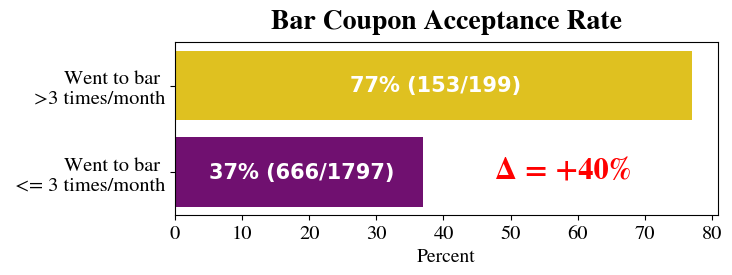

In [270]:
curr_data = bar_coupons
condition0, condition1 = bar_coupons["Bar"].isin(['never', 'less1', '1~3']), bar_coupons["Bar"].isin(['gt8', '4~8'])
text_condition0, text_condition1 =  "Went to bar \n <= 3 times/month", "Went to bar \n  >3 times/month"
colors = {text_condition0: "purple", text_condition1:"gold"}

make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors)[0].show()
plt.savefig("images/bar_coupon_finding1",bbox_inches='tight')

**Figure Takeway:**
The bar coupon acceptance rate of people who went to the bar >3 times/month is **40 percentage points higher** than those who went to the bar <= 3 times per month.

##### 4. Compare the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others.  Is there a difference?  <a name="36"></a>


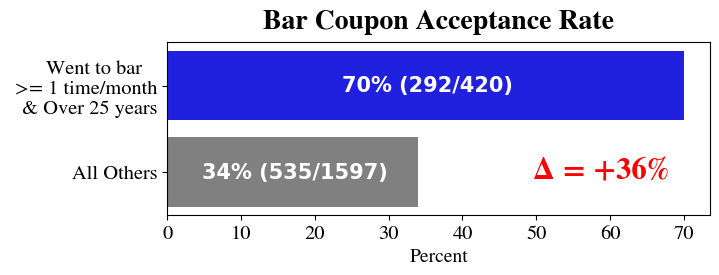

In [271]:
curr_data = bar_coupons
condition1 = bar_coupons["Bar"].isin(['1~3','gt8', '4~8']) & bar_coupons["age"].isin(['46', '26', '31', '41', '50plus', '36'])
condition0 = ~condition1
text_condition1, text_condition0 =  "Went to bar   \n >= 1 time/month\n & Over 25 years", "All Others"
colors = {text_condition0: "grey", text_condition1:"blue"}

make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors)[0].show()
plt.savefig("images/bar_coupon_finding2a", bbox_inches='tight')

**Figure Takeway:**
The bar coupon acceptance rate of people who went to the bar >=1 times/month and over 25 years is **36 percentage points higher** than all others.

##### 5. Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry.  <a name="37"></a>


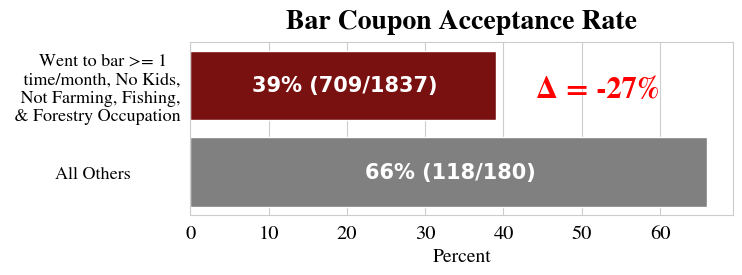

In [ ]:
curr_data = bar_coupons
condition1 = bar_coupons["Bar"].isin(['1~3','gt8', '4~8']) & bar_coupons["has_children"]==0 & ~bar_coupons["occupation"].isin(['Farming Fishing & Forestry'])
condition0 = ~condition1
text_condition1, text_condition0 =  "Went to bar >= 1   \n time/month, No Kids,\n Not Farming, Fishing,\n & Forestry Occupation", "All Others           "
colors = {text_condition0: "grey", text_condition1:"darkred"}

fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, positive_delta=False)
plt.yticks(fontsize=13,color='black', fontname='STIXGeneral')

fig.show()

**Figure Takeway:**
The bar coupon acceptance rate of people who went to the bar >1 times/month and over 25 years is **27 percentage points lower** than all others.

##### 6. Compare the acceptance rates between those drivers who:

- go to bars more than once a month, had passengers that were not a kid, and were not widowed *OR*
- go to bars more than once a month and are under the age of 30 *OR*
- go to cheap restaurants more than 4 times a month and income is less than 50K.   <a name="38"></a>



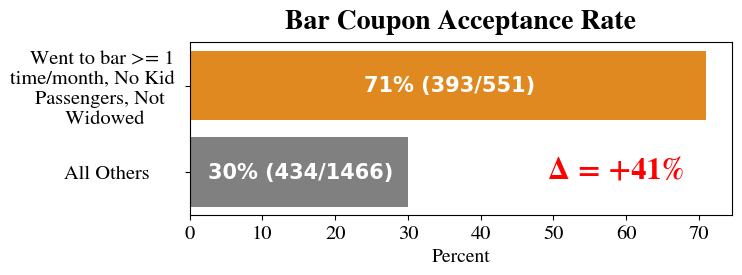

In [273]:
curr_data = bar_coupons
condition1 = bar_coupons["Bar"].isin(['1~3','gt8', '4~8']) & ~bar_coupons["passenger"].isin(['Kid(s)']) & ~bar_coupons["maritalStatus"].isin(['Widowed'])
condition0 = ~condition1
text_condition1, text_condition0 =  "Went to bar >= 1 \ntime/month, No Kid \nPassengers, Not   \n  Widowed       ", "All Others      "
colors = {text_condition0: "grey", text_condition1:"darkorange"}

make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors)[0].show()
plt.savefig("images/bar_coupon_finding3",bbox_inches='tight')

**Figure Takeway:**
The bar coupon acceptance rate of people who went to the bar >=1 times/month, no kid passengers, and not widowed is **41 percentage points higher** than all others.

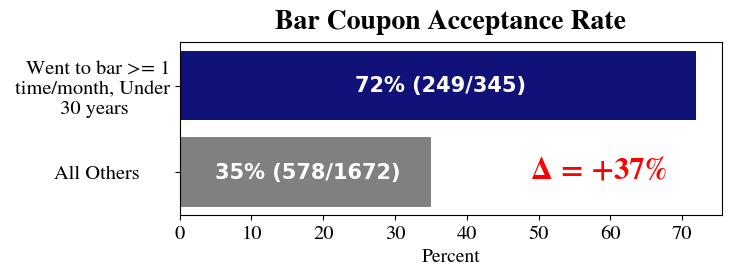

In [272]:
curr_data = bar_coupons
condition1 = bar_coupons["Bar"].isin(['1~3','gt8', '4~8']) & bar_coupons["age"].isin(['below21','21', '26'])
condition0 = ~condition1
text_condition1, text_condition0 =  "Went to bar >= 1\n time/month, Under\n 30 years        ", "All Others      "
colors = {text_condition0: "grey", text_condition1:"darkblue"}

make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors)[0].show()
plt.savefig("images/bar_coupon_finding2b", bbox_inches='tight')

**Figure Takeway:**
The bar coupon acceptance rate of people who went to the bar >=1 times/month and under 30 years is **37 percentage points higher than all others.**

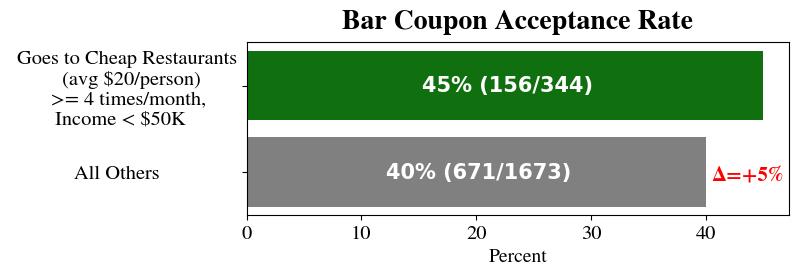

In [274]:
curr_data = bar_coupons
condition1 = bar_coupons["RestaurantLessThan20"].isin(['4~8','gt8']) & bar_coupons["income"].isin(['Less than $12500','$12500 - $24999','$25000 - $37499', '$37500 - $49999'])
condition0 = ~condition1
text_condition1, text_condition0 =  "Goes to Cheap Restaurants\n (avg $20/person)       \n        >= 4 times/month,      \nIncome < $50K          ", "All Others               "
colors = {text_condition0: "grey", text_condition1:"green"}

fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, add_delta=False)

acceptance_rate_data0, _, _ = calculate_acceptance_rate(curr_data.loc[condition0])
acceptance_rate_data1, _, _ = calculate_acceptance_rate( curr_data.loc[condition1])
curr_data = [round(float(acceptance_rate_data0.iloc[0]),2)*100, round(float(acceptance_rate_data1.iloc[0]),2)*100]
diff_text = "Δ=+" + str(int(curr_data[1]-curr_data[0])) + "%"
ax.text(x=46.75, y=1.15, s=diff_text, fontsize=15, color='red', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
fig.show()
plt.savefig("images/bar_coupon_finding4", bbox_inches='tight')

**Figure Takeway:**
The bar coupon acceptance rate of people who goes to cheap restaurants >=4 times per month and have an income of less than $50K is **5 percentage points** higher than all others.

7.  Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

*   <font size=3 color='darkblue'> Going to the bar frequently each month increases bar coupon acceptance rate.
*   Among those that go to the bar at least 1 time per month, having the right age, not having kid passengers, and not being widowed are shown to have around a 70% acceptance rate of a bar coupon.
* Going to cheap restaurants frequently and having a low income results in a slight increase in accepting a bar coupon.<font>


### Independent Investigation <a name="3"></a>

Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons.  

##### 1. Create a new `DataFrame` that contains just coffee house coupons.  <a name="39"></a>

In [13]:
coffeehouse_coupons = data.loc[data["coupon"]=='Coffee House', :]
coffeehouse_coupons.shape

(3996, 26)

##### 2. What proportion of coffee house coupons were accepted?  <a name="40"></a>

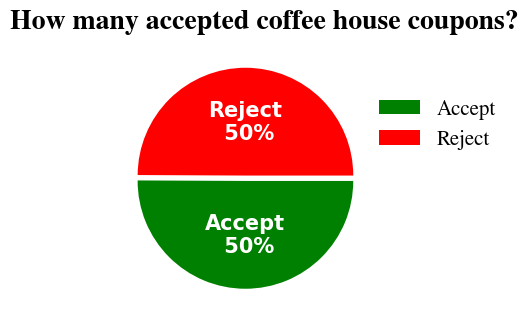

In [22]:
accept_coupon_piechart(coffeehouse_coupons, "How many accepted coffee house coupons?", ['r', 'g'], reverse=True).show()

**Figure Takeways**
50% of coffee house coupons are accepted.

##### 3. Of the observations for coffee house coupon, what are features are correlated with one another? Are there any features correlated with Y - coffee coupon acceptance?
<a name="41"></a>

In [ ]:
# Convert to one hot since they are all categorical variables
one_hot_variables = pd.get_dummies(coffeehouse_coupons)
corr_matrix = one_hot_variables.corr()
corr_matrix_np = corr_matrix.to_numpy()

# Only select correlations with > 0.5 or < -0.5
correlation_values = np.unique(corr_matrix_np.flatten())
correlation_values = correlation_values[(correlation_values > 0.5) | (correlation_values < -0.5)]
correlation_values = correlation_values[correlation_values != 1]

# Reviewed through correlations and included non-obvious correlations
x_idxs, y_idxs = np.where( corr_matrix.isin(correlation_values))
high_correlation_pairs = pd.DataFrame([corr_matrix.columns[x_idxs].tolist(),corr_matrix.index[y_idxs].tolist(), corr_matrix_np[x_idxs.tolist(), y_idxs.tolist()] ]).transpose()
filtered_high_correlation_pairs = high_correlation_pairs.iloc[[3,5,7,12,13,14,18,21,30]]
filtered_high_correlation_pairs.columns = ["Column1", "Column2", "Correlation Value"]
filtered_high_correlation_pairs.style.set_properties(**{'background-color': 'cream'}).format_index(str.upper, axis=1)

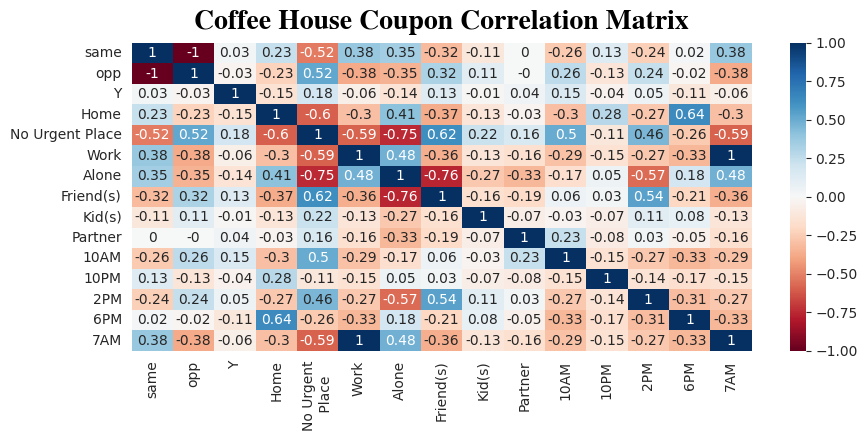

In [ ]:
# Create correlation matrix heatmap based on filtered correlations
corr_cols = ["direction_same", "direction_opp", "destination", "passenger", "time", "Y"]
fig, ax = plt.subplots(figsize=(10, 4))
df = pd.get_dummies(coffeehouse_coupons[corr_cols]).corr().round(2)

# Shorten column names to fit figure
df.columns, df.index = [w.split('_')[1] if w != "Y" else "Y" for w in df.columns], [w.split('_')[1] if w != "Y" else "Y" for w in df.index]
new_cols = df.columns.tolist()
new_cols[4] = 'No Urgent\n Place'
df.columns= new_cols
sns.heatmap(axes=ax, data=df, annot=True, cmap="RdBu")

ax.set_title(label="Coffee House Coupon Correlation Matrix", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()

<font size=3 color='darkblue'>  **Correlations** <font>
*  <font size=3 color='darkblue'>  Going to No Urgent Place and the opposite direction of the coupon has a slight positive correlation. Correspondingly, going to No Urgent Place and the same direction of the coupon has a slight negative correlation.
*   Going to No Urgent Place and having Friend(s) as passengers has a positive correlation. Correspondingly, Going to No Urgent Place and being Alone driving has a negative correlation.
*   Going to No Urgent Place and the time being 10 AM has a slight positive correlation.
*   Going to No Urgent Place and the time being 7 AM has a slight negative correlation.
*   Going Home and the time being 6 PM has a positive correlation.
*   Going with Friends and 2 PM has a slight positive correlation. Correspondingly, going alone and 2 PM has a slight negative correlation.
*   Going to work and 7 AM has a strong positive correlation of 1.    <font>

In [32]:
# For clarity, replace with 0 and 1 with Yes or No for below figures
accepted_coupon = coffeehouse_coupons["Y"].copy()
accepted_coupon = accepted_coupon.astype(str)
accepted_coupon.loc[accepted_coupon=='1'] = "Yes"
accepted_coupon.loc[accepted_coupon=='0'] = "No"

has_children = coffeehouse_coupons["has_children"].copy()
has_children = has_children.astype(str)
has_children.loc[has_children=='1'] = "Yes"
has_children.loc[has_children=='0'] = "No"

##### 4. How does destination affect accepting a coffee house coupon?  
<a name="42"></a>

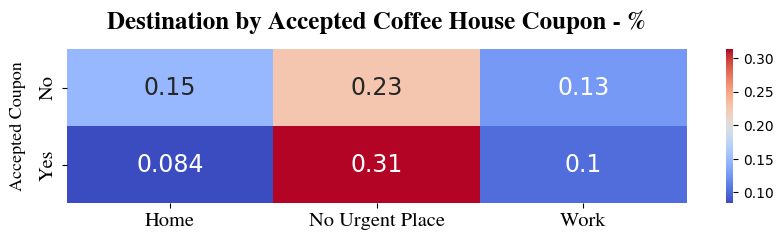

In [33]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.destination, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Destination by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Figure Takeway**: Based on the crosstab above, drivers heading to No Urgent Place are more likely to accept a coffeehouse coupon.

##### 5. What is relationship between coffee house coupon acceptance rate between same direction and opposite direction? <a name="43"></a>

In [34]:
print("The values in direction_opp for people offered coffee house coupons are ",
      coffeehouse_coupons[coffeehouse_coupons.destination == "No Urgent Place"]["direction_opp"].unique())
print("The values in direction_same for people offered coffee house coupons are ",
      coffeehouse_coupons[coffeehouse_coupons.destination == "No Urgent Place"]["direction_same"].unique())

The values in direction_opp for people offered coffee house coupons are  [1]
The values in direction_same for people offered coffee house coupons are  [0]


**Takeway:** When looking at No Urgent Place as the destination, it appears that all of the coffee house coupons were offered only to drivers heading in the opposite direction. <bar>

Therefore, we will not explore direction_same and direction_opp for No Urgent Place as they are the same for all values in coffee house coupons with No Urgent Place as the destination.

##### 6. How is coffee coupon acceptance rate affected by destination? <a name="44"></a>

In [35]:
## Subplot Helper Method
# Used to see overall % distribution of each of the categories of column feature
def subplot_acceptance_rate_by_column(curr_data, var, ax):
  subset = curr_data.groupby([var, "Y"])[["Y"]].count()
  subset.columns = ["percentage"]
  subset = (subset / subset.sum()).reset_index()
  subset = subset.pivot(index=var ,columns="Y", values="percentage")
  ax = sns.countplot(ax=ax, data=curr_data,x="Y", hue=var, stat="percent", palette="pastel", edgecolor="black")
  for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i], fmt="{:.1f}",fontsize=11.75, color="black", padding=0, fontname='STIXGeneral')
  ax.legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.18, 1.01), loc='upper left')  #, bbox_to_anchor=(1.6, 1), loc='upper right')
  ax.set_title(label=var.capitalize() +  " Distribution By\n Coffee House Coupon Acceptance", fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
  ax.set_xlabel(xlabel="Coffee House Coupon Accepted?", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
  ax.set_ylabel(ylabel="Percent", fontdict=dict(fontsize=15,color='black', fontname='STIXGeneral'), labelpad=3)
  ax.tick_params(axis='x', which='both', colors='black', labelsize=10)
  ax.tick_params(axis='y', which='both', colors='black', labelsize=10)
  ax.set_ylim(0, int(subset.max().max()*100+5))
  ax.set_xticks([0,1])
  ax.set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))

In [36]:
## Subplot Helper Method
# Used to see "% Acceptance - % Rejection of each of the categories of column feature
def subplot_difference_coupon_acceptance_by_column(curr_data, var, ax):
  subset = curr_data.groupby([var, "Y"])[["Y"]].count()
  subset.columns = ["percentage"]
  subset = (subset / subset.sum()).reset_index()
  subset = subset.pivot(index=var ,columns="Y", values="percentage")
  subset["% Acceptance - % Rejection"] = (subset[1] - subset[0])*100

  colors = [ 'r' if v <0 else 'g' for v in subset["% Acceptance - % Rejection"]]

  ax = sns.barplot(ax=ax, x=subset.index, y=subset["% Acceptance - % Rejection"], palette=colors, hue=subset.index, edgecolor="black")
  for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i], fmt="{:.2f}",fontsize=11.75, color="black", padding=3, fontname='STIXGeneral')
  ax.set_title(label="% Acceptance - % Rejection by " + var.capitalize(), fontdict=dict(fontsize=15,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
  ax.set_xlabel(xlabel=var.capitalize(), fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
  ax.set_ylabel(ylabel="Percent Diff", fontdict=dict(fontsize=13.5,color='black', fontname='STIXGeneral'), labelpad=3)
  ax.tick_params(axis='x', which='both', colors='black', labelsize=10)
  ax.tick_params(axis='y', which='both', colors='black', labelsize=10)
  ax.set_ylim(min(subset["% Acceptance - % Rejection"])-2, max(subset["% Acceptance - % Rejection"])+2)
  plt.xticks(fontsize=12,color='black', fontname='STIXGeneral')
  plt.yticks(fontsize=12,color='black', fontname='STIXGeneral')

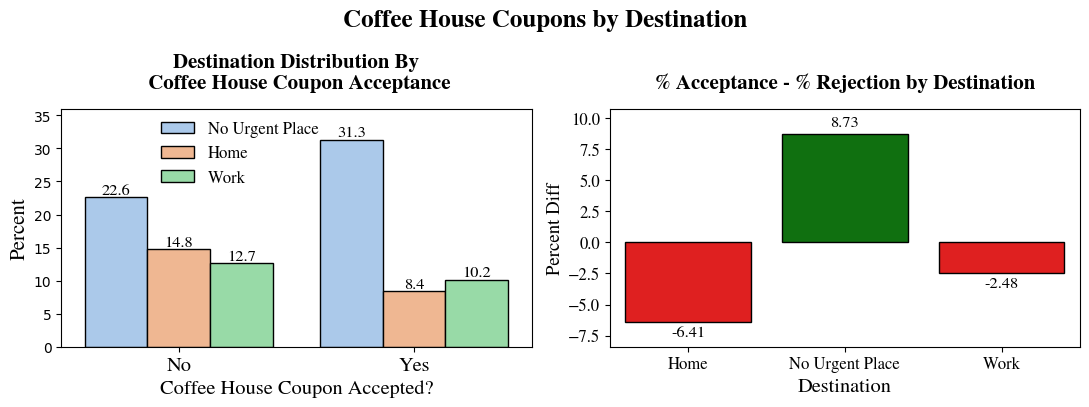

In [77]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "destination"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])

fig.suptitle('Coffee House Coupons by Destination', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_no_urgent_place")

**Takeways:**


*   Similar to the cross-tab above, when a driver is headed towards No Urgent Place, they are more likely to accept a coffee house coupon as there is a positive percentage difference between acceptance and rejection rate.
*   On the contrary, if a driver is headed towards Home or Work, they are less likely to accept a coffee house coupon since as there is a negative percentage difference between acceptance and rejection rates.



##### 7. When looking at offering CoffeeHouse coupons to drivers headed to No Urgent Place, what times are these drivers mostly likely to accept the coupon? <a name="45"></a>

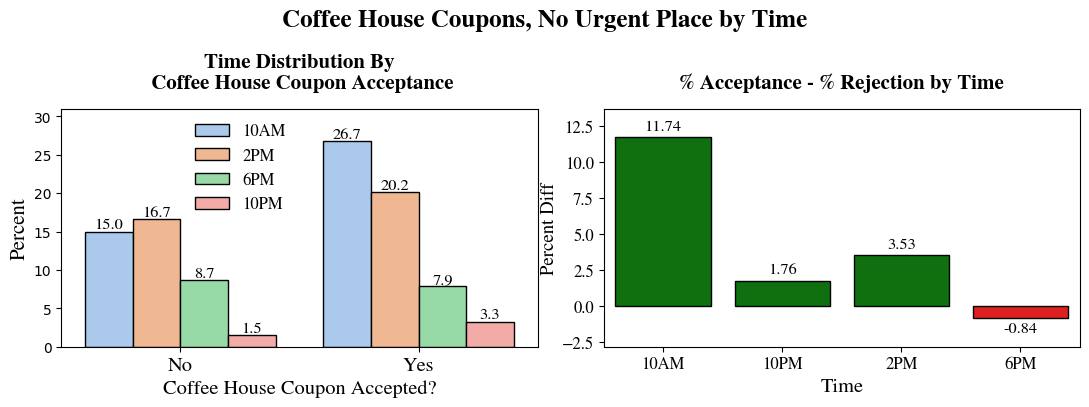

In [78]:
# filter by No Urgent Place

fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "time"
curr_data = coffeehouse_coupons[coffeehouse_coupons.destination == "No Urgent Place"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.25, 1), loc='upper left')

fig.suptitle('Coffee House Coupons, No Urgent Place by Time', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_no_urgent_place_times")

**Takeways:**

*   Drivers headed to No Urgent Place are most likely to accept a coffeehouse coupon at 10 AM, next at 2 PM, and last at 10 PM. This is because the positive difference between the acceptance rate and rejection rate is the highest at 10 AM.
*   Drivers headed to No Urgent Place at 6 PM are likely to reject a coffeehouse coupon as there is a negative differnce between the acceptance rate and rejection rate.


##### 8. When looking at offering CoffeeHouse coupons to drivers headed to No Urgent Place, with what passengers are drivers more likely to accept the coupon? <a name="46"></a>

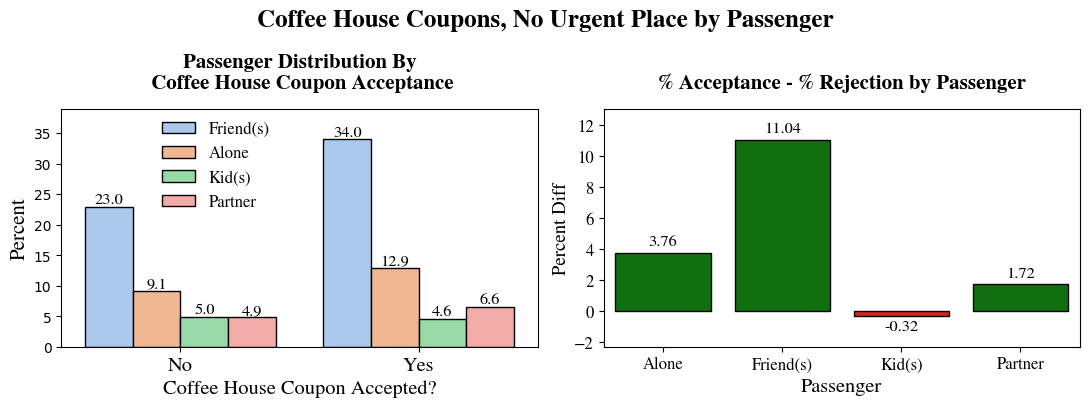

In [79]:
# filter by No Urgent Place

fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "passenger"
curr_data = coffeehouse_coupons[coffeehouse_coupons.destination == "No Urgent Place"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])

fig.suptitle('Coffee House Coupons, No Urgent Place by Passenger', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_no_urgent_place_passengers")

**Takeways:**

*   Drivers headed to No Urgent Place are most likely to accept a coffeehouse coupon with Friend(s) as passengers, next Alone, and last with a Partner. This is because the positive difference between the acceptance rate and rejection rate is the highest with Friend(s).
*   Drivers headed to No Urgent Place with Kid(s) as passengers are likely to reject a coffeehouse coupon as there is a negative differnce between the acceptance rate and rejection rate.

##### 9. When looking at offering CoffeeHouse coupons to drivers headed to Work, with what passengers are drivers more likely to accept the coupon? When looking at offering CoffeeHouse coupons to drivers headed to Work, at what times are drivers more likely to accept the coupon?  <a name="47"></a>

In [28]:
curr_data = coffeehouse_coupons[coffeehouse_coupons.destination == "Work"]
print("When destination is Work, there is only 1 time: ", curr_data["time"].unique())
print("When destination is Work, there is only 1 passenger type: ", curr_data["passenger"].unique())

When destination is Work, there is only 1 time:  ['7AM']
When destination is Work, there is only 1 passenger type:  ['Alone']


**Takeaway:**

*  Since when the destination is Work for Coffee House coupons, there is only 1 time and 1 passenger type. This does not give us any useful information to distinguish between Coffee House acceptance rate.
*  In general, when looking at destination as Work and only at CoffeeHouse coupons, drivers are more likely to reject the CoffeHouse coupon since there is a negative difference between the acceptance and rejection rate.  This is seen in an above visual and also below.

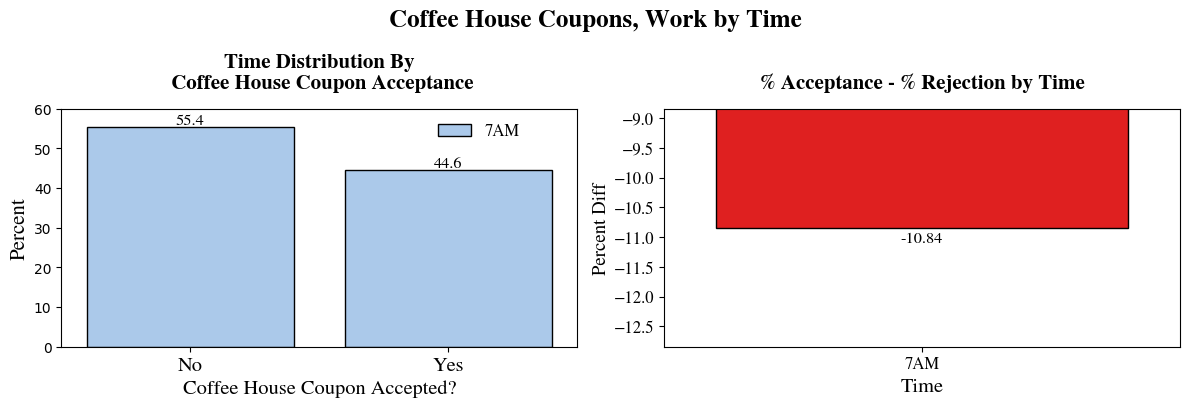

In [45]:
# filter by Work

fig, axes = plt.subplots(1,2,figsize=(12,4.11))
curr_data = coffeehouse_coupons[coffeehouse_coupons.destination == "Work"]
var = "time"

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.7, 1), loc='upper left')
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])

fig.suptitle('Coffee House Coupons, Work by Time', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()


fig.show()

##### 10. When looking at offering CoffeeHouse coupons to drivers headed to Home, at what times are drivers more likely to accept the coupon? When looking at offering CoffeeHouse coupons to drivers headed Home, with what passengers are drivers more likely to accept the coupon?  <a name="48"></a>

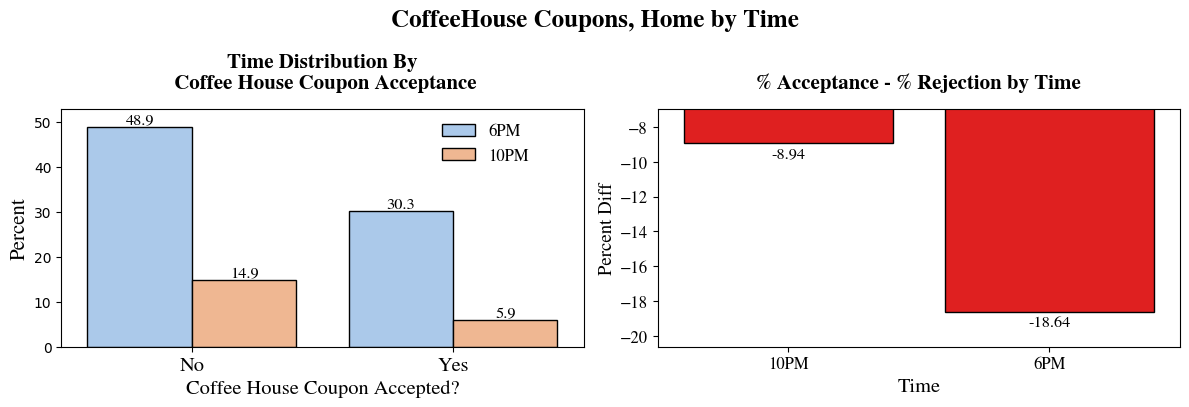

In [40]:
# Filter by Home
fig, axes = plt.subplots(1,2,figsize=(12,4.11))
var = "time"
curr_data = coffeehouse_coupons[coffeehouse_coupons.destination == "Home"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.7, 1), loc='upper left')
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])

fig.suptitle('Coffee House Coupons, Home by Time', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeaways**

*  At both times, a driver is mostly likely to reject a CoffeeHouse coupon if the driver's destination is Home.

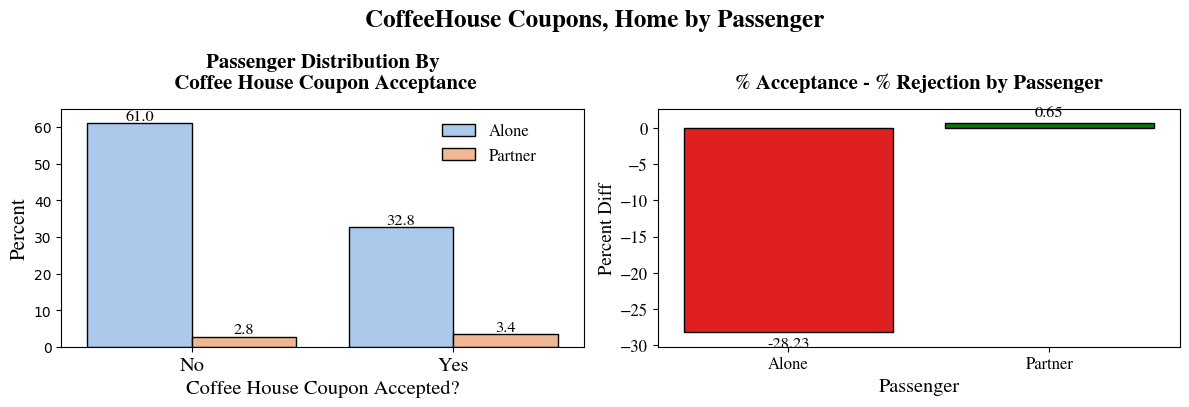

In [41]:
# Filter by Home
fig, axes = plt.subplots(1,2,figsize=(12,4.11))
var = "passenger"
curr_data = coffeehouse_coupons[coffeehouse_coupons.destination == "Home"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.7, 1), loc='upper left')
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])

fig.suptitle('Coffee House Coupons, Home by Passenger', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeaways**

*  With no passengers alone, a driver is more likely to reject a CoffeeHouse coupon if the driver's destination is Home since there is a negative difference between the acceptance and rejection rate.
*  If the driver is headed Home and has a Partner as a passenger, a driver is more likely to accept a CoffeeHouse coupon since there is a slight positive difference between the acceptance and rejection rate.

##### 11. How does the passenger affect if a driver accepts a CoffeeHouse coupon?  <a name="49"></a>

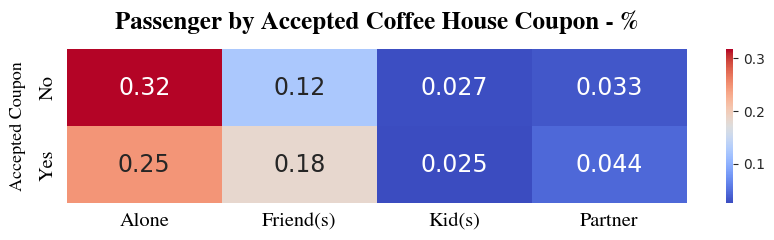

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.passenger, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Passenger by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeaways**


*   If a driver is Alone, the percentage for not accepting a CoffeeHouse coupon is higher, so the driver is more likely to reject the CoffeeHouse coupon.
*   If the driver is with Friend(s) or with Partner, the percentage for accepting a CoffeeHouse coupon is higher, so the driver is more likely to accept the CoffeeHouse coupon.



##### 12. How is coffee coupon acceptance rate affected by passengers?  <a name="50"></a>

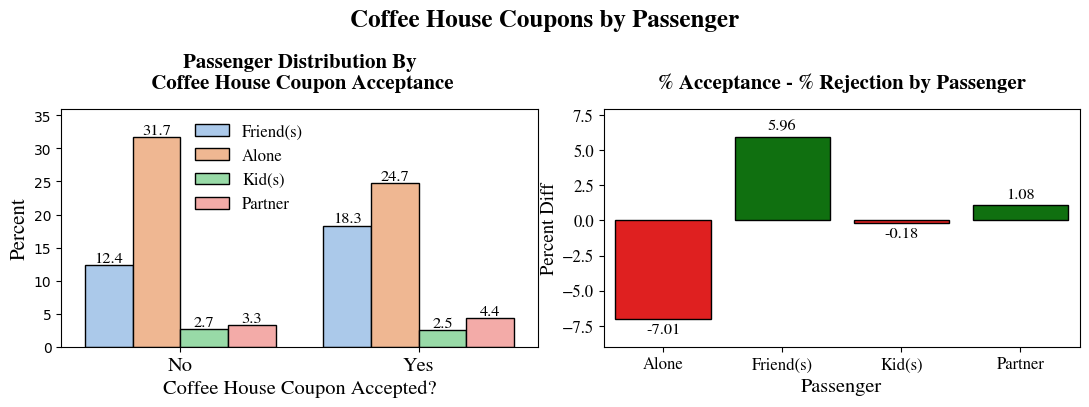

In [80]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "passenger"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.25, 1), loc='upper left')

fig.suptitle('Coffee House Coupons by Passenger', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_friend_passengers")

##### 13. For Alone drivers with no passengers, what time are they most likely to accept a CoffeeHouse coupon?  <a name="51"></a>

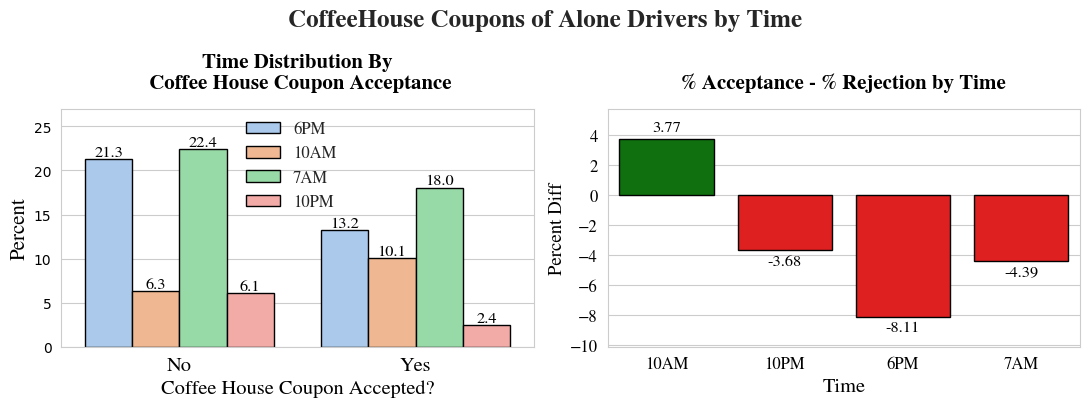

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "time"
curr_data = coffeehouse_coupons[coffeehouse_coupons.passenger == "Alone"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.36, 1.01), loc='upper left')

fig.suptitle('CoffeeHouse Coupons of Alone Drivers by Time', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeway:** Alone drivers are more likely to accept a CoffeeHouse coupon at 10 AM since there is a positive difference between the acceptance and rejection rate.

##### 14. For Alone drivers with no passengers, what gender is most likely to accept a CoffeeHouse coupon? <a name="52"></a>

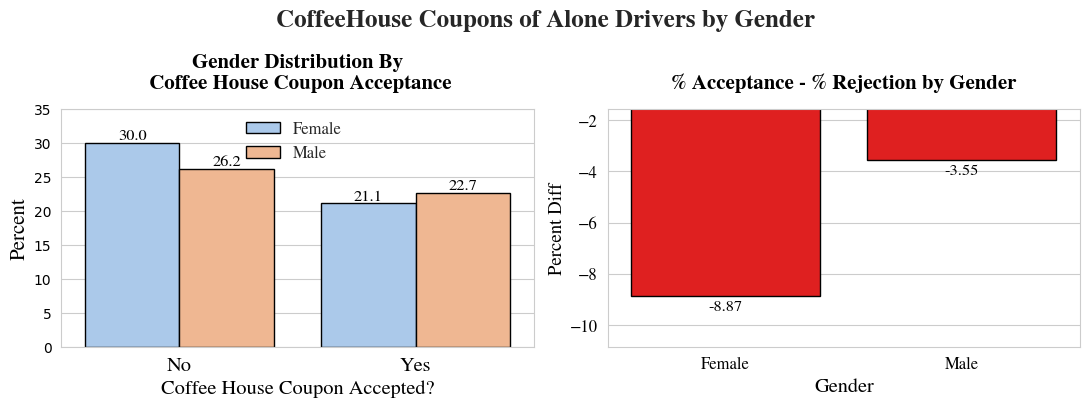

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "gender"
curr_data = coffeehouse_coupons[coffeehouse_coupons.passenger == "Alone"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.36, 1.01), loc='upper left')

fig.suptitle('Coffee House Coupons of Alone Drivers by Gender', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeway** : Being either male or female does not increase the likelihood of accepting a CoffeeHouse as an Alone driver.

##### 15. For Alone drivers with no passengers, what age is most likely to accept a CoffeeHouse coupon? <a name="53"></a>

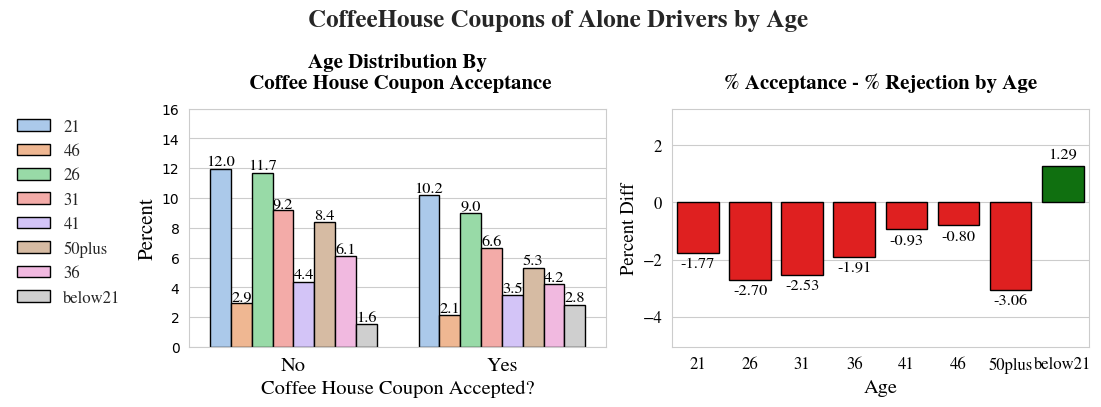

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "age"
curr_data = coffeehouse_coupons[coffeehouse_coupons.passenger == "Alone"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.45, 1.02), loc='upper left')

fig.suptitle('Coffee House Coupons of Alone Drivers by Age', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeway** : These are Alone drivers below 21 who are more likely to accept a CoffeeHouse coupon as there is a positive difference between the acceptance and rejection rate.

##### 16. For drivers with Friend(s) as passengers, what time is most likely to accept a CoffeeHouse coupon ?  <a name="54"></a>

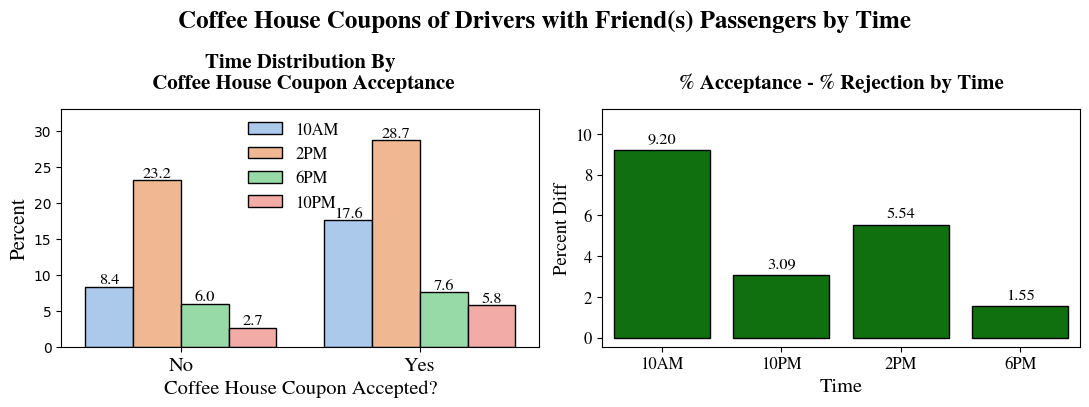

In [81]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "time"
curr_data = coffeehouse_coupons[coffeehouse_coupons.passenger == "Friend(s)"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.36, 1.01), loc='upper left')

fig.suptitle('Coffee House Coupons of Drivers with Friend(s) Passengers by Time', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_friend_passengers_times")

**Takeaway**: Every time point. The highest likelihood is at 10 AM because then is the highest positive difference between the acceptance and rejection rate.

##### 17. For drivers with their Partner as a passenger, what time is most likely to accept a CoffeeHouse coupon ? <a name="55"></a>

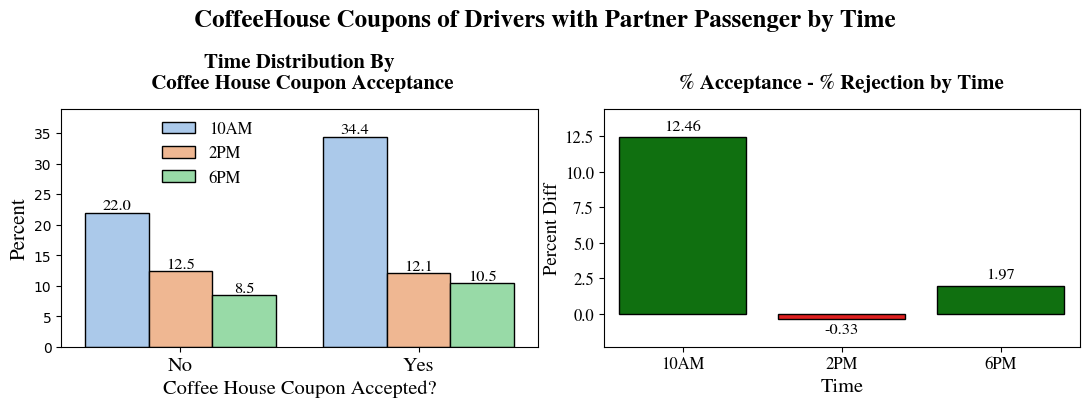

In [82]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "time"
curr_data = coffeehouse_coupons[coffeehouse_coupons.passenger == "Partner"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])
#axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.2, 1.01), loc='upper left')

fig.suptitle('CoffeeHouse Coupons of Drivers with Partner Passenger by Time', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_partner_partner_times")

**Takeaway** Both 10 AM and 6 PM, but there is a higher likelihood at 10 AM of a driver with their Partner as a Passenger accepting a CoffeeHouse coupon since the positive difference between the acceptance rate and rejection rate is the highest.

##### 18. How does weather affect if a driver accepts a CoffeeHouse coupon? <a name="56"></a>

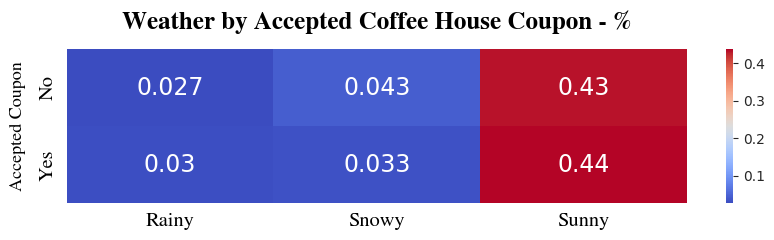

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.weather, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Weather by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeaway**
*   Most of the data is Sunny, and accepting and rejecting a coupon have a similar percentage with Sunny weather for Coffee House coupons.



##### 19. How is the coffee coupon acceptance rate affected by weather? <a name="57"></a>

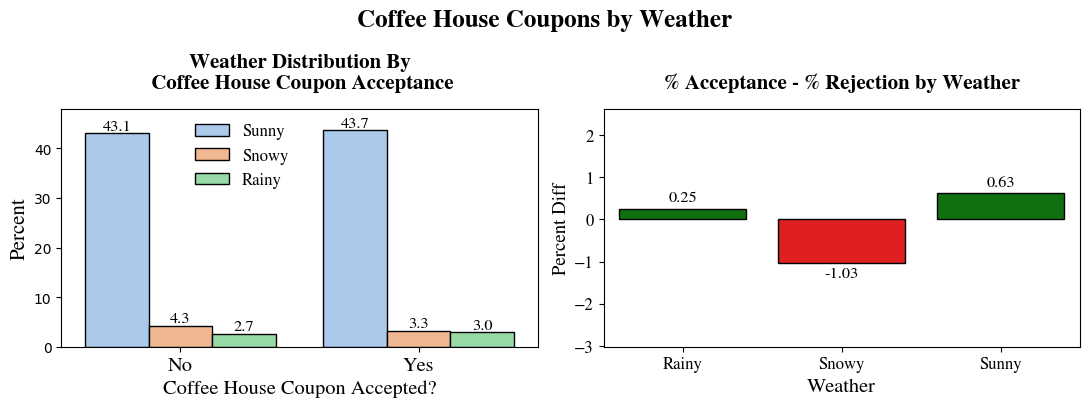

In [49]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "weather"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.25, 1), loc='upper left')

fig.suptitle('Coffee House Coupons by Weather', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeways**

*   There is a slight positive difference between the rainy and sunny categories, so they are slightly more likely to accept a Coffee House under these two weather categories.
*   Drivers are less likely to accept a Coffee House coupon under Snowy weather as seen by the negative difference between acceptance and rejection rate.



##### 20. How does temperature affect if a driver accepts a CoffeeHouse coupon? <a name="58"></a>

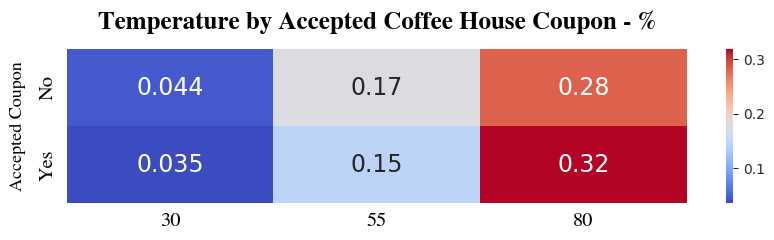

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.temperature, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Temperature by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeway**: Most of the data points are at 80 degrees temperature. There is slight increase in percentage among those that accept coupon at 80 degrees and those reject at 80 degrees.

##### 21. How is the coffee coupon acceptance rate affected by temperature? <a name="59"></a>


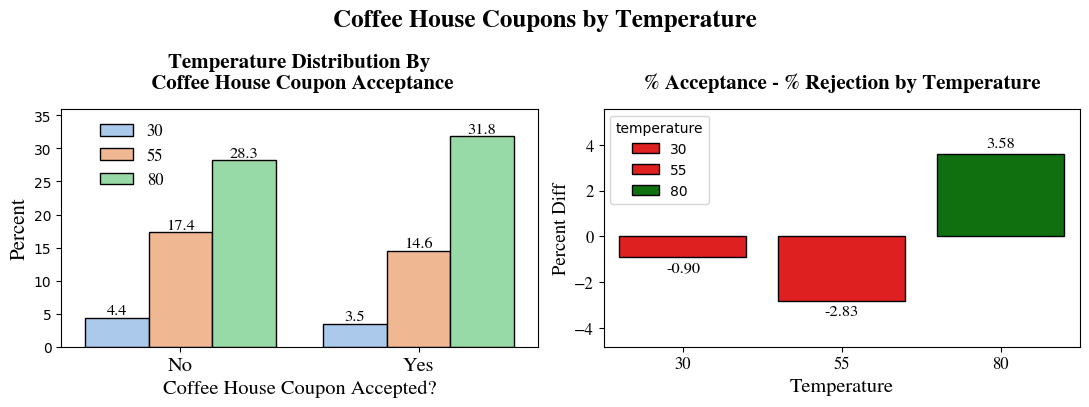

In [50]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "temperature"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(0.05, 1), loc='upper left')

fig.suptitle('Coffee House Coupons by Temperature', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeaway:**  80 degrees Temperature results in a positive increase in accepting a Coffee House coupon.

##### 22. How does time affect if a driver accepts a CoffeeHouse coupon? <a name="60"></a>



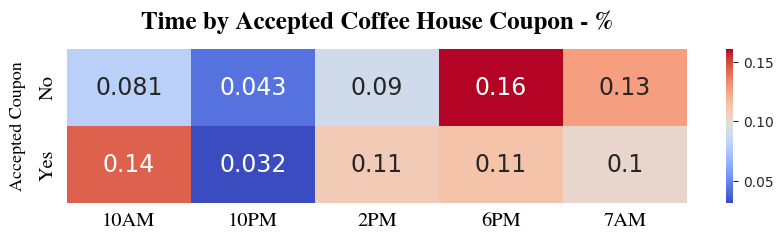

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.time, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Time by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeaways**
*   10 AM much more likely to accept Coffee House with larger difference in percentage between "Yes" and "No". Slightly more likely to accept at 2 PM.
*   Less likely to accept at 6 PM and 7 AM.



##### 23. How is the coffee coupon acceptance rate affected by time? <a name="61"></a>

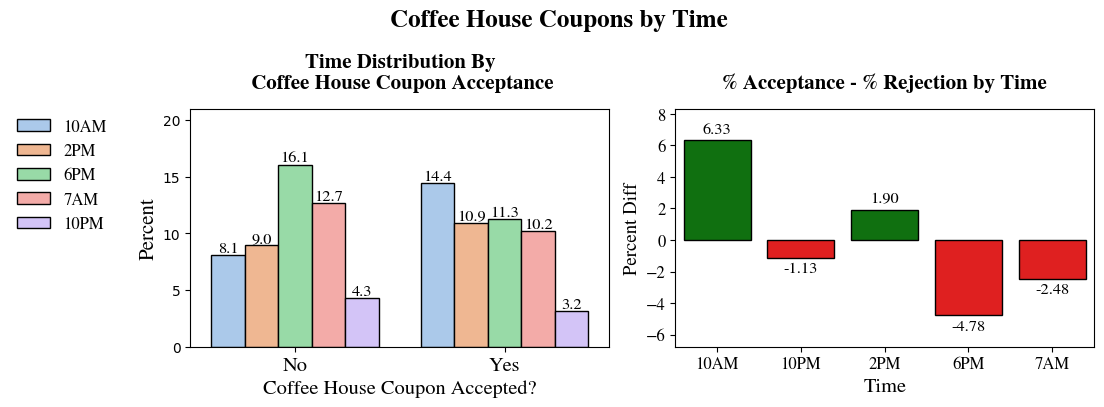

In [83]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "time"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.45, 1.02), loc='upper left')

fig.suptitle('Coffee House Coupons by Time', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_time")

**Takeaways**
*   10 AM much more likely to accept Coffee House with larger difference in percentage between "Yes" and "No". Also, likely to accept at 2 PM.
*   Less likely to accept at 6 PM and 7 AM.

##### 24. How is the coffee coupon acceptance rate affected by expiration date? <a name="62"></a>

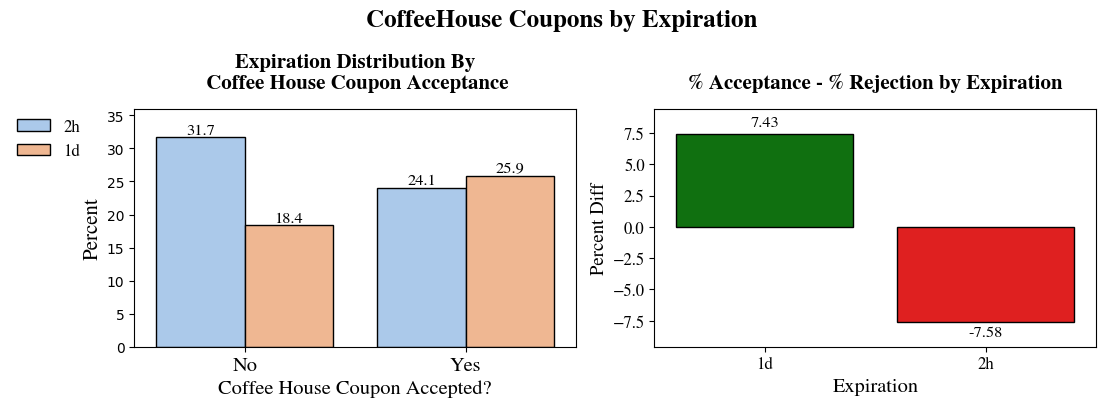

In [85]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "expiration"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.3, 1.02), loc='upper left')

fig.suptitle('CoffeeHouse Coupons by Expiration', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_expiration")

**Takeaway** : Coupons that expire in 1 day are more likely to accepted than rejected. Coupons that expire in 2h are less likely to be accepted than rejected.

##### 25. How does gender affect if a driver accepts a CoffeeHouse coupon?  <a name="63"></a>

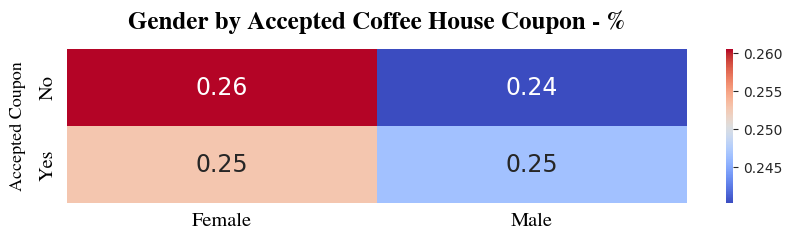

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.gender, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Gender by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeaway**: There not much percentage difference across genders for those that accept versus reject a Coffee House coupon.

##### 26. How is the coffee coupon acceptance rate affected by gender? <a name="64"></a>

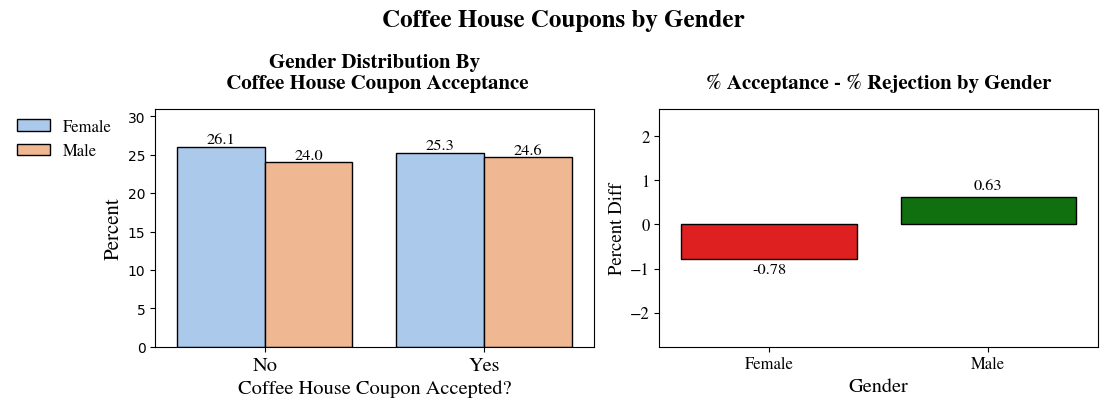

In [52]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "gender"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.35, 1.02), loc='upper left')

fig.suptitle('Coffee House Coupons by Gender', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeaway**: There are small percentage differences across genders for those that accept versus reject a Coffee House coupon.

##### 27. How is the coffee coupon acceptance rate affected by age? <a name="65"></a>

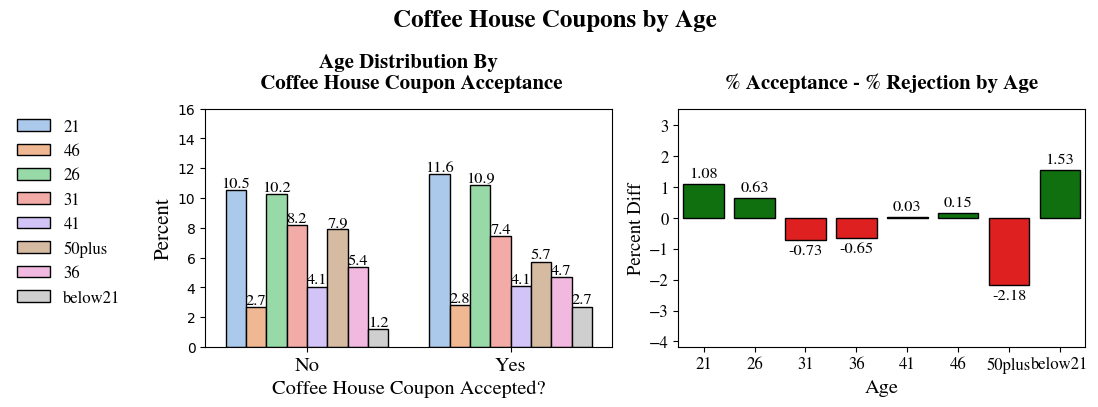

In [53]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "age"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.5, 1.02), loc='upper left')

fig.suptitle('Coffee House Coupons by Age', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeaway**: Below 21 and 21 are more likely to accept a Coffee House Coupon while 50 plus are more likely to reject.

##### 28. How does marital status affect if a driver accepts a CoffeeHouse coupon? <a name="66"></a>

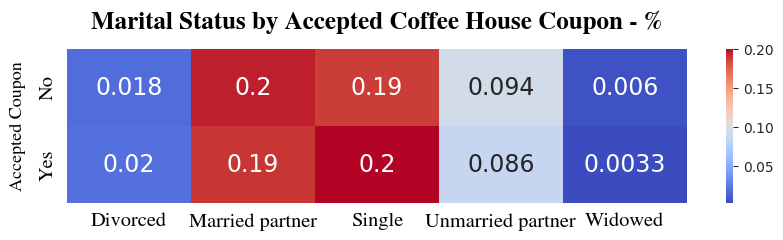

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.maritalStatus, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Marital Status by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeaway** Married and Single are more frequent in the data set and have similar percentages for accepting or reject a Coffee House coupon.

##### 29. How is the coffee coupon acceptance rate affected by marital status? <a name="67"></a>

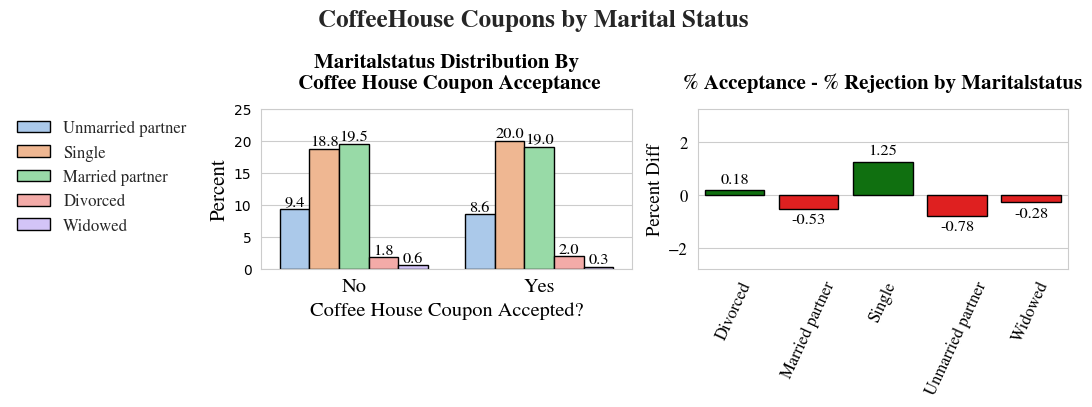

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "maritalStatus"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.7, 1.02), loc='upper left')
plt.xticks(rotation=65)
axes[1].set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)


fig.suptitle('CoffeeHouse Coupons by Marital Status', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeaway** Those that are Single are slighly more likely to accept than reject a Coffee House coupon.

##### 30. How does having children affect if a driver accepts a CoffeeHouse coupon? <a name="68"></a>

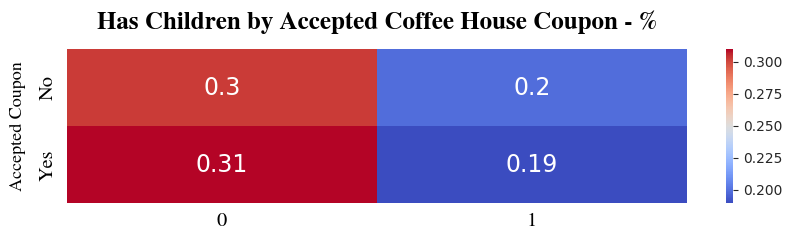

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.has_children, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Has Children by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeaway: ** Not much difference acrossing having or not having children and accepting or rejecting a Coffee House coupon.

##### 31. How is the coffee coupon acceptance rate affected by having children? <a name="69"></a>

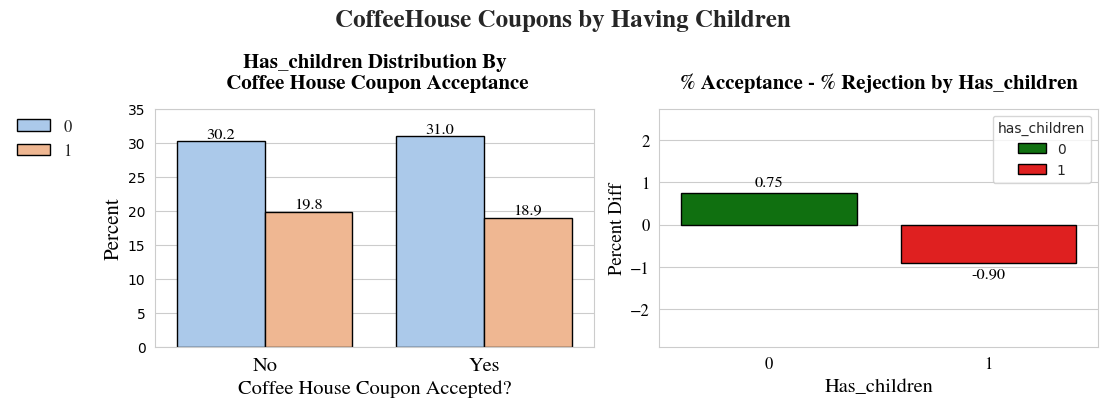

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "has_children"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.35, 1.02), loc='upper left')

fig.suptitle('CoffeeHouse Coupons by Having Children', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeaway:** Not much difference acrossing having or not having children and accepting or rejecting a Coffee House coupon.

##### 32. How does education affect if a driver accepts a CoffeeHouse coupon? <a name="70"></a>

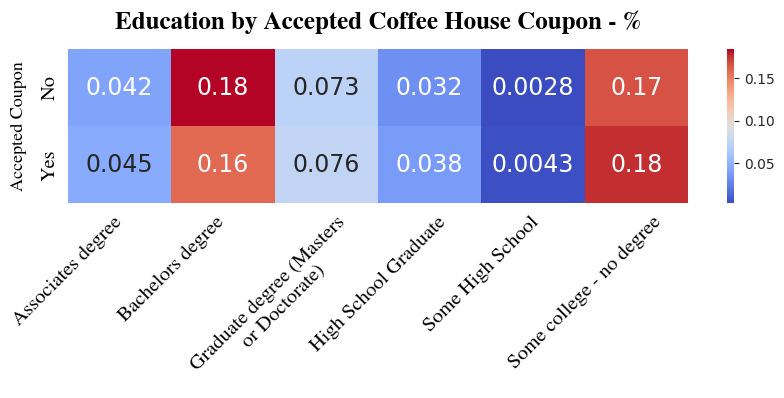

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.education, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Education by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')

# update long label to go on next line
curr_xlabels = ax.get_xticklabels()
curr_xlabels[2] = 'Graduate degree (Masters\n or Doctorate)'
ax.set_xticks(range(6))
ax.set_xticklabels(curr_xlabels)

plt.xticks(rotation=45)


fig.show()

**Takeaway** There are more people who have either a Bachelor's degree or Some college - no degree than other education levels. Those with a Bachelor's degree have a slightly higher percentage of rejecting a Coffee House coupon. Those with some high school and some college have slightly higher percentages of accepting a Coffee House coupon.

##### 33. How is the coffee coupon acceptance rate affected by education? <a name="71"></a>

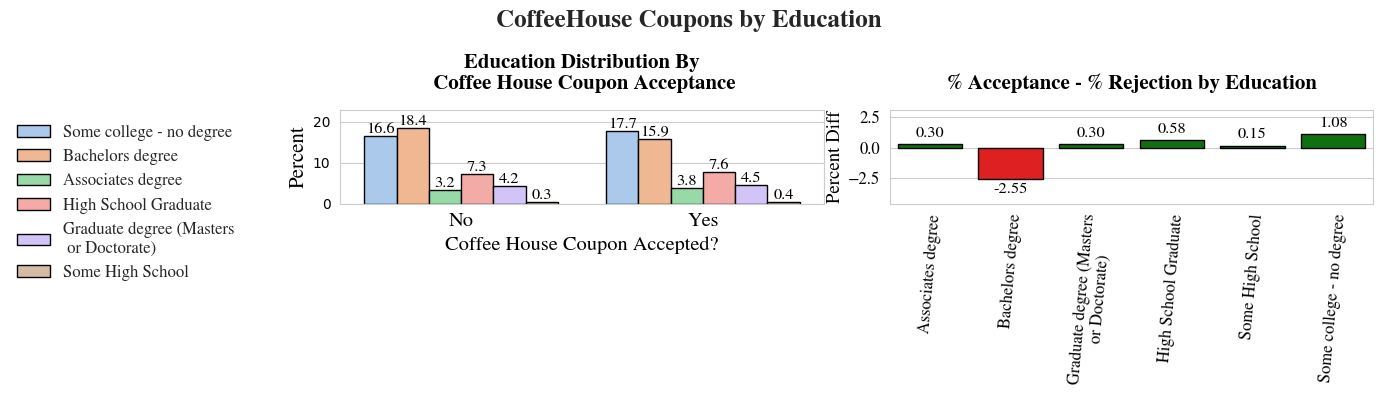

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,4))
var = "education"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
custom_labels = ['Some college - no degree', 'Bachelors degree',
       'Associates degree', 'High School Graduate',
       'Graduate degree (Masters\n or Doctorate)', 'Some High School']
axes[0].legend(labels=custom_labels,  frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.7, 1), loc='upper left')

# update long label to go on next line
curr_xlabels = axes[1].get_xticklabels()
curr_xlabels[2] = 'Graduate degree (Masters\n or Doctorate)'
axes[1].set_xticks(range(6))
axes[1].set_xticklabels(curr_xlabels)
axes[1].set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)


plt.xticks(rotation=85)

fig.suptitle('CoffeeHouse Coupons by Education', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeaway**: Those drivers with Bachelor's degrees offered a Coffee House coupon are slightly more likely to reject it.

##### 34. How does occupation affect if a driver accepts a CoffeeHouse coupon? <a name="72"></a>

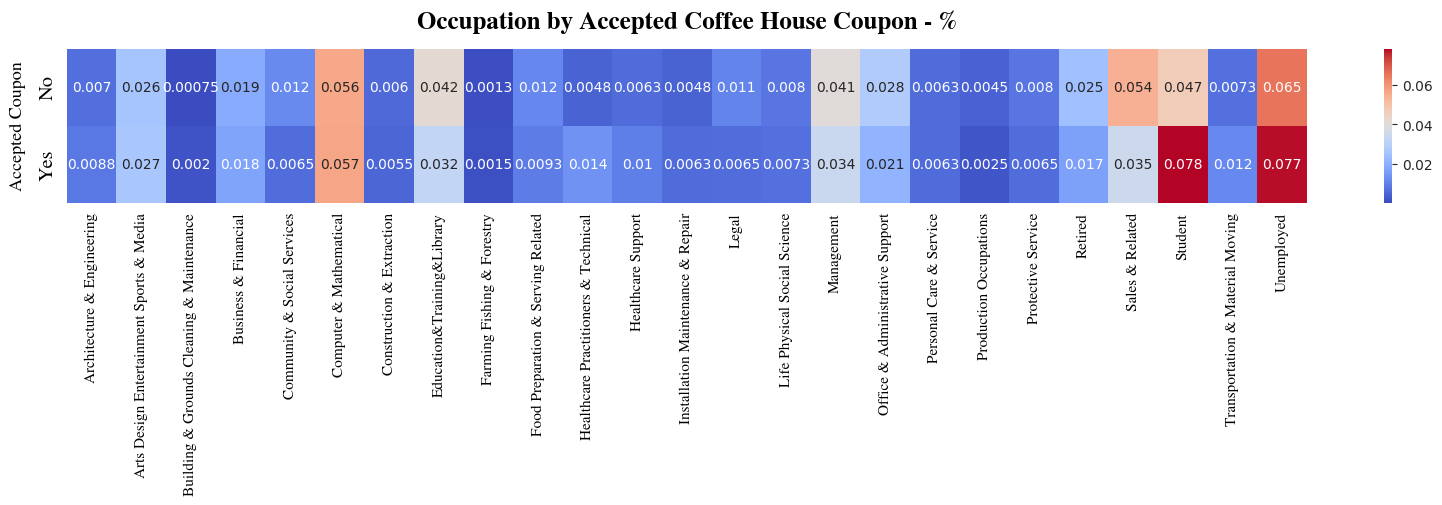

In [ ]:
fig, ax = plt.subplots(figsize=(20, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.occupation, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=10))

# add label formatting
ax.set_title("Occupation by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=11,color='black', fontname='STIXGeneral')

plt.xticks(rotation=90)
plt.xlabel("")
# Update long labels to go on next line
curr_xlabels = ax.get_xticklabels()
#curr_xlabels[1] = 'Arts Design Entertainment\n Sports & Media'
#curr_xlabels[2] =  'Building & Grounds Cleaning\n & Maintenance'
#ax.set_xticks(range(25))
#ax.set_xticklabels(curr_xlabels)

fig.show()

**Takeaway**: Students and Unemployed are more likely to accept a Coffee House coupon.

##### 35. How is the coffee coupon acceptance rate affected by occupation? <a name="73"></a>

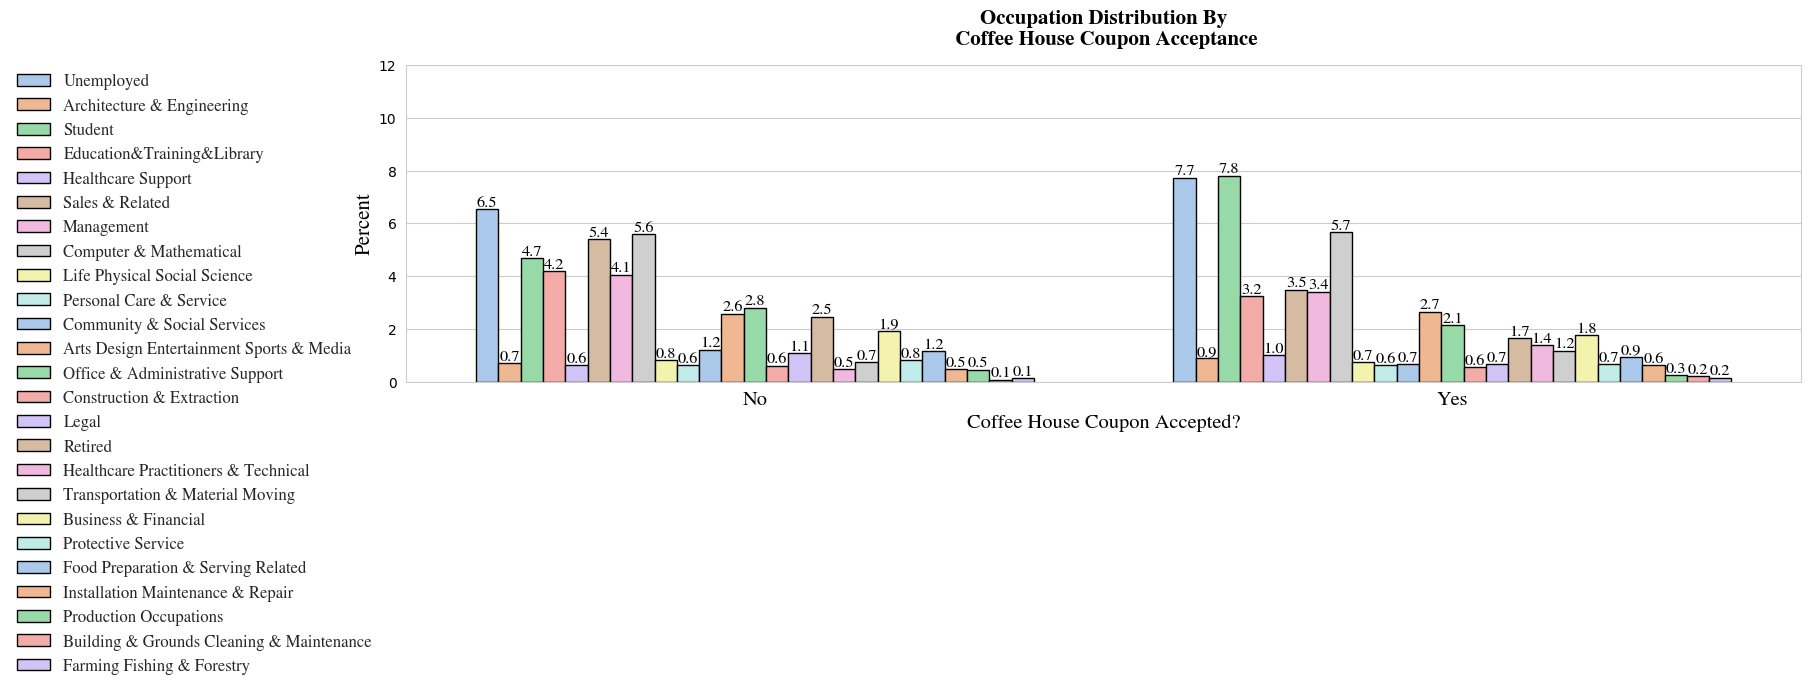

In [ ]:
fig1, ax1 = plt.subplots(figsize=(18,4.11))
subplot_acceptance_rate_by_column(coffeehouse_coupons, var, ax1)
ax1.legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.29, 1.02), loc='upper left')


##### 36. For students, are they more likely to go to Coffee House location is less than 15 min away? <a name="74"></a>

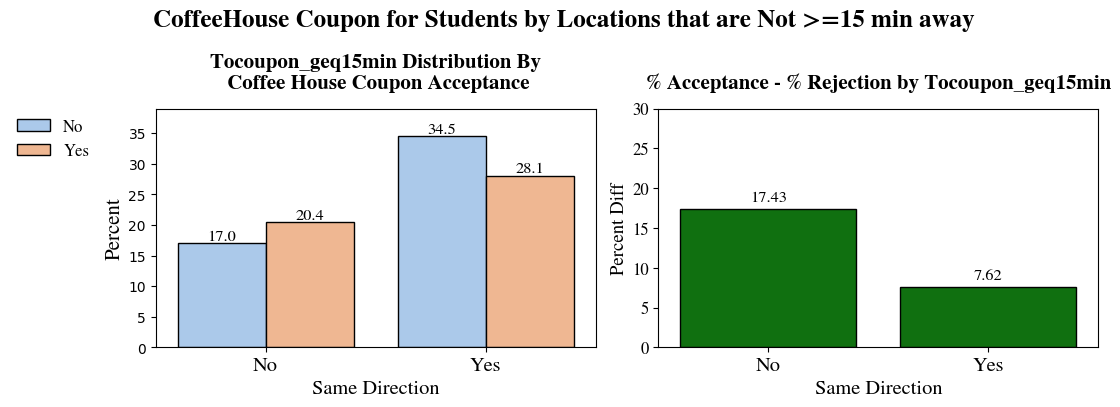

In [119]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "toCoupon_GEQ15min"
curr_data = coffeehouse_coupons[coffeehouse_coupons["occupation"] == "Student"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])
axes[0].legend(labels=["No","Yes"], frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.35, 1.02), loc='upper left')

axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="Same Direction", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Same Direction", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
plt.ylim(0, 30)
plt.legend().set_visible(False)

fig.suptitle('CoffeeHouse Coupon for Students by Locations that are Not >=15 min away', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_students_lessthan15min_away")

**Takeaway**: Students receiving Coffee House coupons for places less than 15 minutes away are likely to accept the coupon.

##### 37. For students, are they more likely to go to Coffee House location is less than 25 min away? <a name="75"></a>

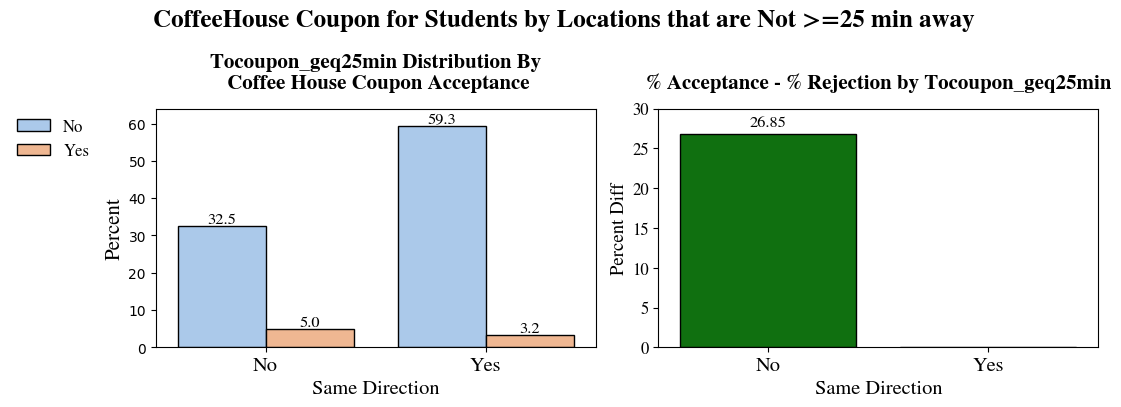

In [118]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "toCoupon_GEQ25min"
curr_data = coffeehouse_coupons[coffeehouse_coupons["occupation"] == "Student"]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])
axes[0].legend(labels=["No","Yes"], frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.35, 1.02), loc='upper left')

axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="Same Direction", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Same Direction", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
plt.ylim(0, 30)
plt.legend().set_visible(False)

fig.suptitle('CoffeeHouse Coupon for Students by Locations that are Not >=25 min away', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_students_lessthan25min_away")

**Takeaway**: Students receiving Coffee House coupons for places less than 25 minutes away are likely to accept the coupon.

##### 38. How does income affect if a driver accepts a CoffeeHouse coupon? <a name="76"></a>

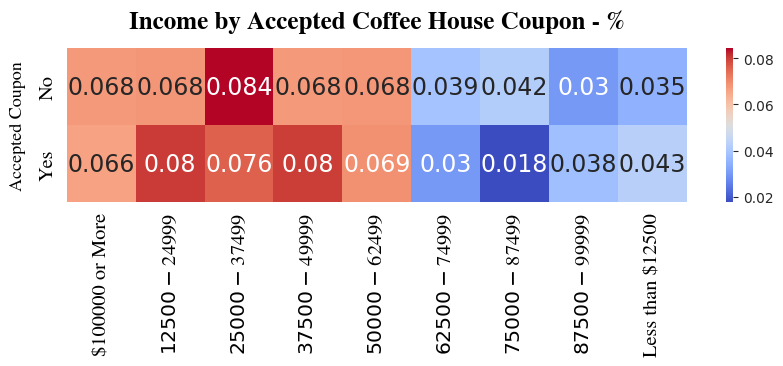

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.income, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Income by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeaway**  Incomes are distributed and there are some small, but not substantial percent differences.

##### 39. How is the coffee coupon acceptance rate affected by income? <a name="77"></a>

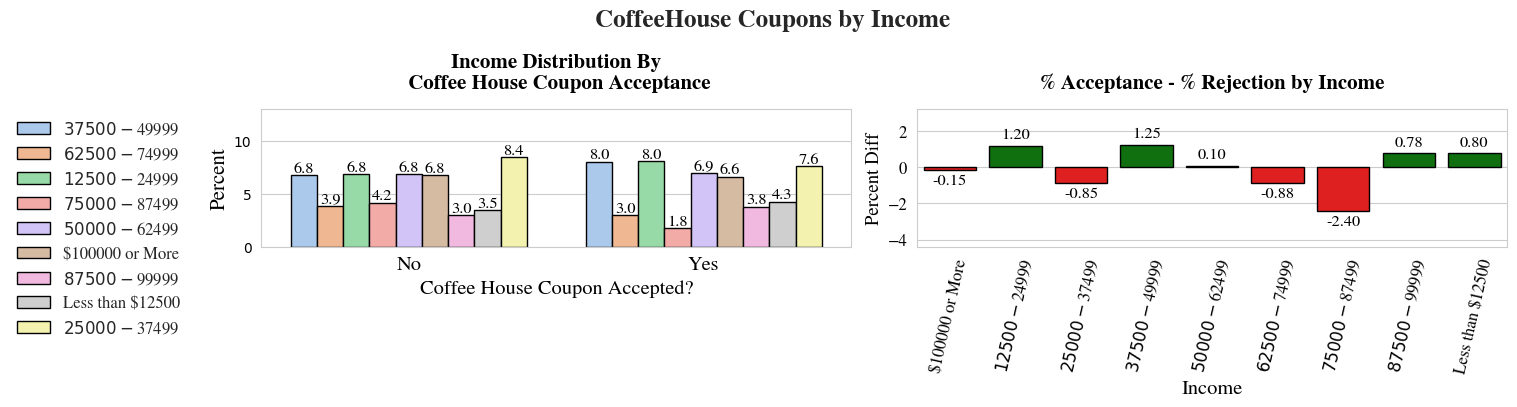

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(15,4.11))
var = "income"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.44, 1.02), loc='upper left')
axes[1].tick_params(axis='x', which='both', colors='black', labelrotation=77)

fig.suptitle('CoffeeHouse Coupons by Income', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeaway**  There are some small, but not substantial percent differences with income.

##### 40. How does monthly Coffee House visit frequency affect if a driver accepts a CoffeeHouse coupon? <a name="78"></a>

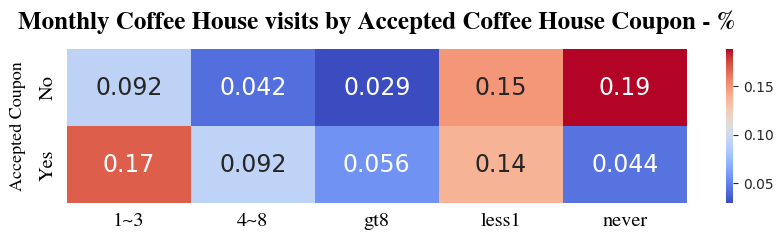

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.CoffeeHouse, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Monthly Coffee House visits by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeaway**  There are some small, but not substantial percent differences.

##### 41. How is the coffee coupon acceptance rate affected by monthly Coffee House visits? <a name="79"></a>

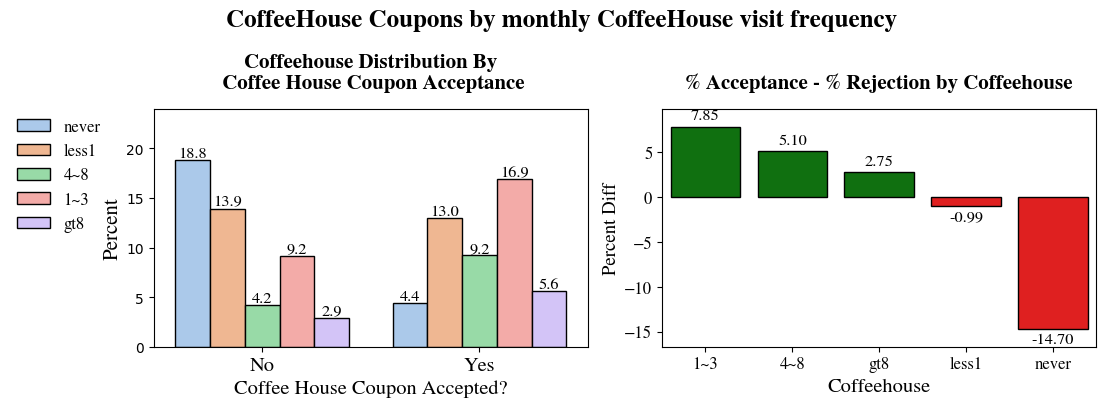

In [86]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "CoffeeHouse"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.35, 1.02), loc='upper left')

fig.suptitle('CoffeeHouse Coupons by monthly Coffee House visit frequency', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_coupon_visit_frequency")

**Takeaway**: Those visiting the Coffee House 1-3 times/month and in general >=1 time/month are more likely to accept a Coffee House coupon.

##### 42. How does the greater than or equal 15 minutes from the Coffee House coupon location affect if a driver accepts a Coffee House coupon? <a name="80"></a>

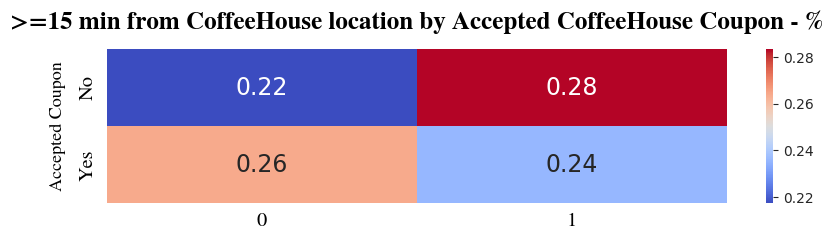

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.toCoupon_GEQ15min, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title(">=15 min from CoffeeHouse location by Accepted CoffeeHouse Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeaway**  There are some small, but not substantial percent differences.

##### 43. How is the coffee coupon acceptance rate affected by being >= 15 minutes from CoffeeHouse location? <a name="81"></a>

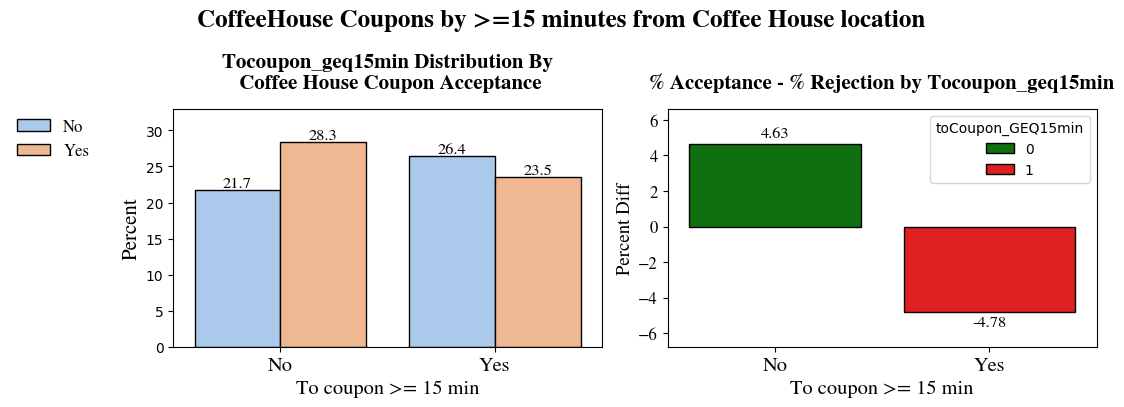

In [120]:

fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "toCoupon_GEQ15min"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.35, 1.02), loc='upper left')

axes[0].legend( labels=["No", "Yes"], frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.4, 1.02), loc='upper left')

axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="To coupon >= 15 min", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="To coupon >= 15 min", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)

fig.suptitle('CoffeeHouse Coupons by >=15 minutes from Coffee House location', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()


**Takeway** Coupons to nearby Coffee Houses are more likely to be accepted.

##### 44. How does being greater than or equal 25 minutes from the CoffeeHouse coupon location affect if a driver accepts a CoffeeHouse coupon? <a name="82"></a>

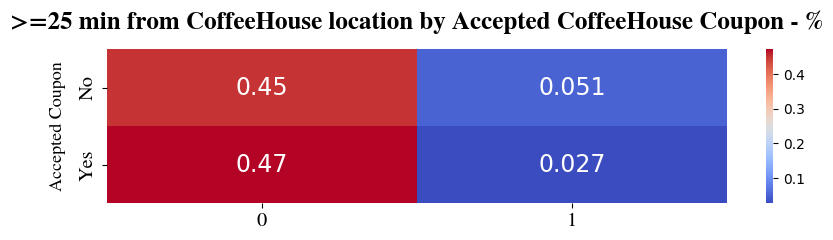

In [47]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.toCoupon_GEQ25min, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title(">=25 min from CoffeeHouse location by Accepted CoffeeHouse Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()


**Takeaway**  There are some small, but not substantial percent differences.

##### 45. How is the coffee coupon acceptance rate affected by being >= 25 minutes away from coupon location?  <a name="83"></a>

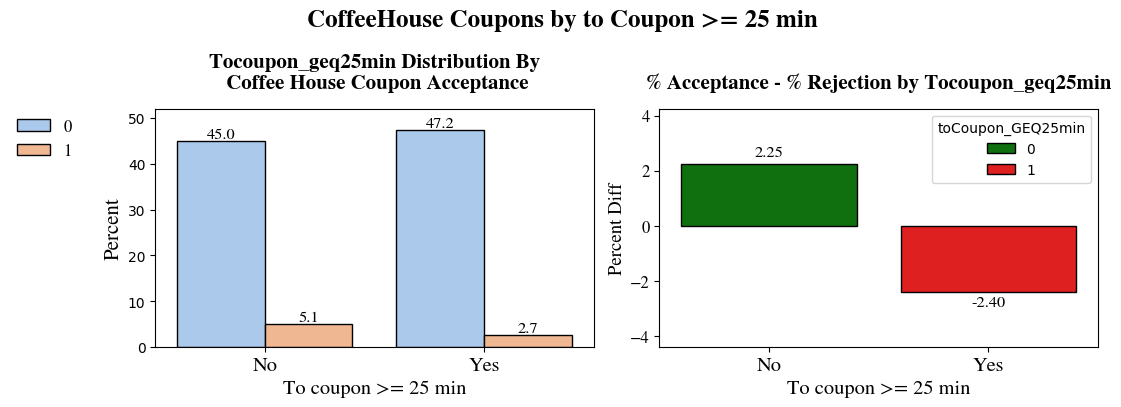

In [122]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "toCoupon_GEQ25min"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.35, 1.02), loc='upper left')
axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="To coupon >= 25 min", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="To coupon >= 25 min", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.suptitle('CoffeeHouse Coupons by to Coupon >= 25 min', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeway** Coupons to nearby Coffee Houses are more likely to be accepted.

##### 46. How does being in the same direction as coupon location affect if a driver accepts a CoffeeHouse coupon? <a name="84"></a>

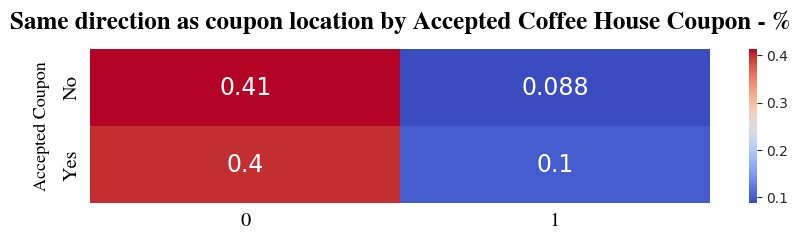

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.direction_same, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Same direction as coupon location by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()


**Takeaway**  There are some small, but not substantial percent differences.

##### 47. How is the coffee coupon acceptance rate affected by being in the same direction as the coupon location? <a name="85"></a>

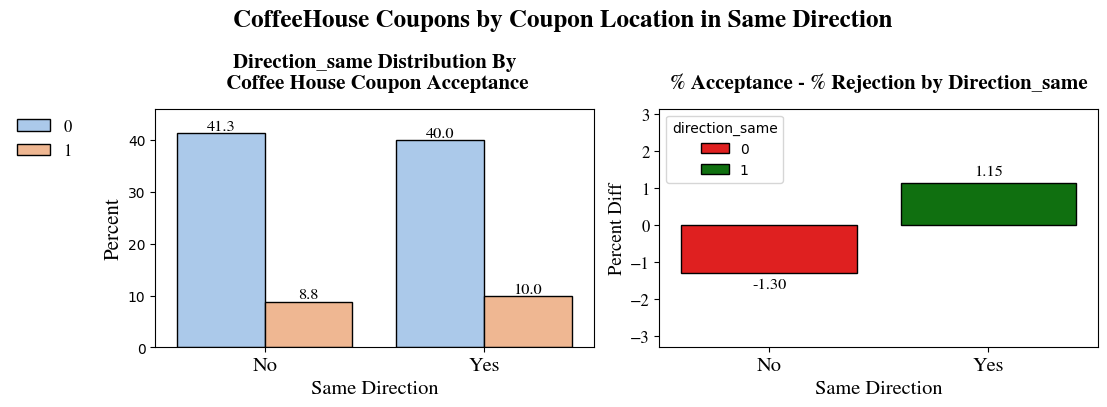

In [123]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "direction_same"

subplot_acceptance_rate_by_column(coffeehouse_coupons, var, axes[0])
subplot_difference_coupon_acceptance_by_column(coffeehouse_coupons, var, axes[1])
axes[0].legend(frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.35, 1.02), loc='upper left')
axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="Same Direction", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Same Direction", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
fig.suptitle('CoffeeHouse Coupons by to Coupon >= 25 min', fontsize=18, fontname='STIXGeneral', fontweight="bold")

fig.suptitle('CoffeeHouse Coupons by Coupon Location in Same Direction', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

**Takeaway** Small positive percentage for accepting a coupon in same direction.

##### 48. How does being in a different direction as coupon location affect if a driver accepts a CoffeeHouse coupon? <a name="86"></a>

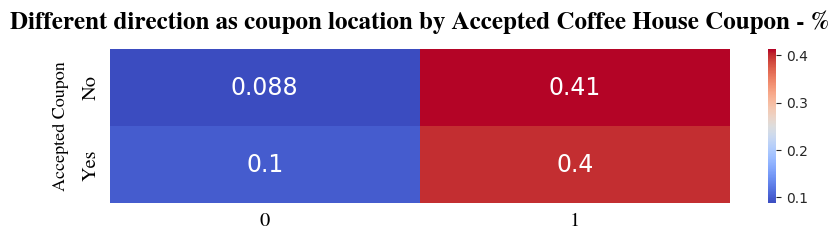

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# Create heap map of cross tabulation of Y and destination
sns.heatmap(axes=ax, data=pd.crosstab(accepted_coupon, coffeehouse_coupons.direction_opp, normalize=True), annot=True, cmap="coolwarm", annot_kws=dict(size=17))

# add label formatting
ax.set_title("Different direction as coupon location by Accepted Coffee House Coupon - %", fontdict=dict(fontsize=18,fontweight='bold',color='black', fontname='STIXGeneral'), pad=15)
ax.set_xlabel(xlabel="", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
ax.set_ylabel(ylabel="Accepted Coupon", fontdict=dict(fontsize=13,color='black', fontname='STIXGeneral'), labelpad=10)
ax.tick_params(axis='x', which='both', colors='black', labelsize=13)
ax.tick_params(axis='y', which='both', colors='black', labelsize=13)
plt.yticks(fontsize=14.65,color='black', fontname='STIXGeneral')
plt.xticks(fontsize=14.65,color='black', fontname='STIXGeneral')
fig.show()

**Takeaway**  There are some small, but not substantial percent differences.

##### 49. If the coupon location is not greater than 15 minutes away, is it more likely to accept a Coffee House coupon if in the same direction? <a name="87"></a>

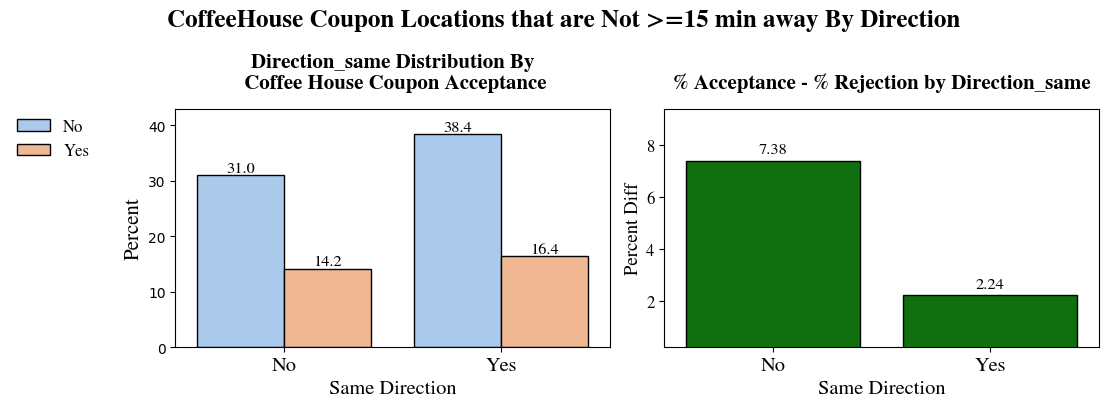

In [124]:
fig, axes = plt.subplots(1,2,figsize=(11,4.11))
var = "direction_same"

curr_data = coffeehouse_coupons[coffeehouse_coupons["toCoupon_GEQ15min"] ==0]

subplot_acceptance_rate_by_column(curr_data, var, axes[0])
subplot_difference_coupon_acceptance_by_column(curr_data, var, axes[1])
axes[0].legend( labels=["No", "Yes"], frameon=False, prop=dict(family='STIXGeneral', size=12), bbox_to_anchor=(-0.4, 1.02), loc='upper left')

axes[0].set_xticks([0,1])
axes[1].set_xticks([0,1])
axes[0].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[1].set_xticklabels(["No", "Yes"], fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'))
axes[0].set_xlabel(xlabel="Same Direction", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)
axes[1].set_xlabel(xlabel="Same Direction", fontdict=dict(fontsize=14.65,color='black', fontname='STIXGeneral'), labelpad=4)

plt.legend().set_visible(False)

fig.suptitle('CoffeeHouse Coupon Locations that are Not >=15 min away By Direction', fontsize=18, fontname='STIXGeneral', fontweight="bold")
plt.tight_layout()

fig.show()

plt.savefig("images/coffee_house_get15min_same_direction")

**Takeway**: For coupons to coffee locations less than 15 minutes away, drivers are more likely to accept the coupon if it's in the same direction.

In [201]:
def finding1():
  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["destination"].isin(["No Urgent Place"])
  condition0 = ~condition1
  text_condition0, text_condition1 =  "All Others", "No Urgent Place"
  colors = {text_condition0: "grey", text_condition1:"purple"}

  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, add_delta=False)
  acceptance_rate_data0, _, _ = calculate_acceptance_rate(curr_data.loc[condition0])
  acceptance_rate_data1, _, _ = calculate_acceptance_rate( curr_data.loc[condition1])
  curr_data = [round(float(acceptance_rate_data0.iloc[0]),2)*100, round(float(acceptance_rate_data1.iloc[0]),2)*100]
  diff_text = "Δ=+" + str(int(curr_data[1]-curr_data[0])) + "%"
  ax.text(x=55, y=1.15, s=diff_text, fontsize=20, color='red', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["destination"].isin(["No Urgent Place"]) & coffeehouse_coupons["time"].isin(["10AM"])  & coffeehouse_coupons["passenger"].isin(["Friend(s)"])
  condition0 = ~condition1
  text_condition0, text_condition1 =  "All Others", "No Urgent\n Place, 10AM,\n         Friend(s)   \n       Passenger   "
  colors = {text_condition0: "grey", text_condition1:"orange"}
  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors)
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

In [215]:
def finding2():
  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["time"].isin(["10AM"])
  condition0 = ~condition1
  text_condition0, text_condition1 =  "All Others", "10AM"
  colors = {text_condition0: "grey", text_condition1:"green"}

  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, add_delta=False)
  acceptance_rate_data0, _, _ = calculate_acceptance_rate(curr_data.loc[condition0])
  acceptance_rate_data1, _, _ = calculate_acceptance_rate( curr_data.loc[condition1])
  curr_data = [round(float(acceptance_rate_data0.iloc[0]),2)*100, round(float(acceptance_rate_data1.iloc[0]),2)*100]
  diff_text = "Δ=+" + str(int(curr_data[1]-curr_data[0])) + "%"
  ax.text(x=63, y=1.15, s=diff_text, fontsize=20, color='red', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["time"].isin(["10AM"])  & coffeehouse_coupons["passenger"].isin(["Friend(s)"])
  condition0 = ~condition1
  text_condition0, text_condition1 =  "All Others", "10AM, \nFriend(s) \nPassenger"
  colors = {text_condition0: "grey", text_condition1:"blue"}
  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors)
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

In [214]:
def finding3():
  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["passenger"].isin(["Friend(s)"]) #&  coffeehouse_coupons["time"].isin(["10AM"])
  condition0 = ~condition1
  text_condition0, text_condition1 =  "All Others", "Friend(s)"
  colors = {text_condition0: "grey", text_condition1:"purple"}

  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, add_delta=False)
  acceptance_rate_data0, _, _ = calculate_acceptance_rate(curr_data.loc[condition0])
  acceptance_rate_data1, _, _ = calculate_acceptance_rate( curr_data.loc[condition1])
  curr_data = [round(float(acceptance_rate_data0.iloc[0]),2)*100, round(float(acceptance_rate_data1.iloc[0]),2)*100]
  diff_text = "Δ=+" + str(int(curr_data[1]-curr_data[0])) + "%"
  ax.text(x=61, y=1.15, s=diff_text, fontsize=20, color='red', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["passenger"].isin(["Friend(s)"]) &  coffeehouse_coupons["time"].isin(["10AM"])
  condition0 = ~condition1
  text_condition0, text_condition1 =  "All Others", "Friend(s)\n10AM"
  colors = {text_condition0: "grey", text_condition1:"orange"}

  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, add_delta=False)
  acceptance_rate_data0, _, _ = calculate_acceptance_rate(curr_data.loc[condition0])
  acceptance_rate_data1, _, _ = calculate_acceptance_rate( curr_data.loc[condition1])
  curr_data = [round(float(acceptance_rate_data0.iloc[0]),2)*100, round(float(acceptance_rate_data1.iloc[0]),2)*100]
  diff_text = "Δ=+" + str(int(curr_data[1]-curr_data[0])) + "%"
  ax.text(x=67, y=1.15, s=diff_text, fontsize=20, color='red', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

In [221]:
def finding4():
  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["expiration"].isin(["1d"]) #&  coffeehouse_coupons["time"].isin(["10AM"])
  condition0 = ~condition1
  text_condition0, text_condition1 =  "All Others", "Expires 1d"
  colors = {text_condition0: "grey", text_condition1:"purple"}

  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, add_delta=False)
  acceptance_rate_data0, _, _ = calculate_acceptance_rate(curr_data.loc[condition0])
  acceptance_rate_data1, _, _ = calculate_acceptance_rate( curr_data.loc[condition1])
  curr_data = [round(float(acceptance_rate_data0.iloc[0]),2)*100, round(float(acceptance_rate_data1.iloc[0]),2)*100]
  diff_text = "Δ=+" + str(int(curr_data[1]-curr_data[0])) + "%"
  ax.text(x=58, y=1.15, s=diff_text, fontsize=20, color='red', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

In [232]:
def finding5():
  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["CoffeeHouse"].isin(['4~8', '1~3', 'gt8']) #&  coffeehouse_coupons["time"].isin(["10AM"])
  condition0 = ~condition1
  text_condition0, text_condition1 =  "All Others", ">=1/month \nvisit CoffeeHouse"
  colors = {text_condition0: "grey", text_condition1:"blue"}

  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, add_delta=False)
  acceptance_rate_data0, _, _ = calculate_acceptance_rate(curr_data.loc[condition0])
  acceptance_rate_data1, _, _ = calculate_acceptance_rate( curr_data.loc[condition1])
  curr_data = [round(float(acceptance_rate_data0.iloc[0]),2)*100, round(float(acceptance_rate_data1.iloc[0]),2)*100]
  diff_text = "Δ=+" + str(int(curr_data[1]-curr_data[0])) + "%"
  ax.text(x=61, y=1.15, s=diff_text, fontsize=20, color='red', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["CoffeeHouse"].isin([ '1~3']) #&  coffeehouse_coupons["time"].isin(["10AM"])
  condition0 = ~condition1
  text_condition0, text_condition1 =  "All Others", "1-3/month \nvisit CoffeeHouse"
  colors = {text_condition0: "grey", text_condition1:"green"}

  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, add_delta=False)
  acceptance_rate_data0, _, _ = calculate_acceptance_rate(curr_data.loc[condition0])
  acceptance_rate_data1, _, _ = calculate_acceptance_rate( curr_data.loc[condition1])
  curr_data = [round(float(acceptance_rate_data0.iloc[0]),2)*100, round(float(acceptance_rate_data1.iloc[0]),2)*100]
  diff_text = "Δ=+" + str(int(curr_data[1]-curr_data[0])) + "%"
  ax.text(x=61, y=1.15, s=diff_text, fontsize=20, color='red', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

In [256]:
def finding6():
  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["toCoupon_GEQ15min"].isin([0]) & coffeehouse_coupons["occupation"].isin(["Student"])
  condition0 = ~condition1
  text_condition0, text_condition1 =  "All Others", "Students\nTo Coupon < 15 min"
  colors = {text_condition0: "grey", text_condition1:"purple"}

  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, add_delta=False)
  acceptance_rate_data0, _, _ = calculate_acceptance_rate(curr_data.loc[condition0])
  acceptance_rate_data1, _, _ = calculate_acceptance_rate( curr_data.loc[condition1])
  curr_data = [round(float(acceptance_rate_data0.iloc[0]),2)*100, round(float(acceptance_rate_data1.iloc[0]),2)*100]
  diff_text = "Δ=+" + str(int(curr_data[1]-curr_data[0])) + "%"
  ax.text(x=64, y=1.15, s=diff_text, fontsize=18, color='red', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

  curr_data = coffeehouse_coupons
  condition1 = coffeehouse_coupons["toCoupon_GEQ25min"].isin([0]) & coffeehouse_coupons["occupation"].isin(["Student"])
  text_condition0, text_condition1 =  "All Others", "Students\nTo Coupon < 25 min"
  colors = {text_condition0: "grey", text_condition1:"orange"}

  fig, ax = make_comparison_bargraph(curr_data, condition0, condition1, text_condition0, text_condition1, colors, add_delta=False)
  acceptance_rate_data0, _, _ = calculate_acceptance_rate(curr_data.loc[condition0])
  acceptance_rate_data1, _, _ = calculate_acceptance_rate( curr_data.loc[condition1])
  curr_data = [round(float(acceptance_rate_data0.iloc[0]),2)*100, round(float(acceptance_rate_data1.iloc[0]),2)*100]
  diff_text = "Δ=+" + str(int(curr_data[1]-curr_data[0])) + "%"
  ax.text(x=63, y=1.15, s=diff_text, fontsize=18, color='red', fontweight='bold', fontname='STIXGeneral', ha='right', va='bottom')
  ax.set_title(label="Coffee House Coupon Acceptance Rate", fontdict=dict(fontsize=20,fontweight='bold',color='black', fontname='STIXGeneral'), pad=10)
  fig.show()

## Findings <a name="88"></a>

### **Finding 1.** No Urgent Place destination has around 20% higher acceptance rate than that of all others <a name="89"></a>

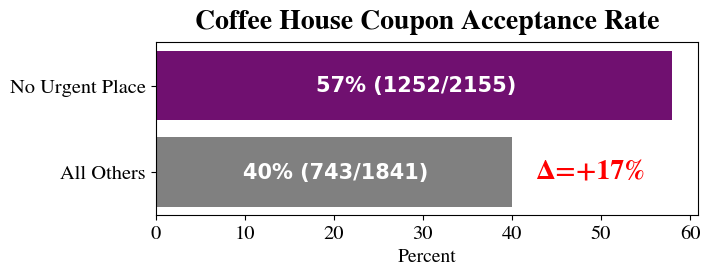

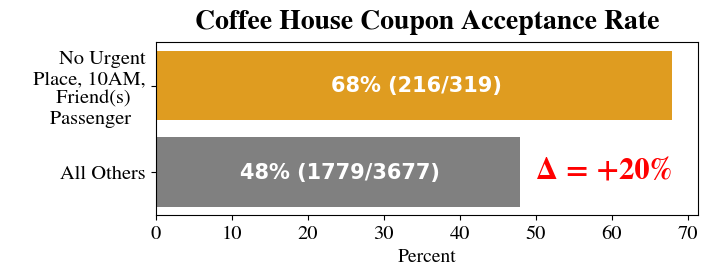

In [277]:
finding1()
plt.savefig("images/coffeehouse_coupon_finding1", bbox_inches='tight')

### **Finding 2.** 10 AM time has around 20% higher acceptance than that of all others  <a name="90"></a>

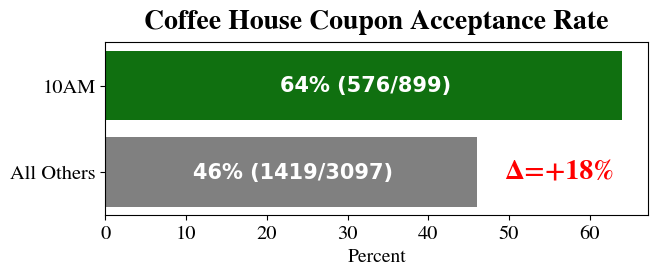

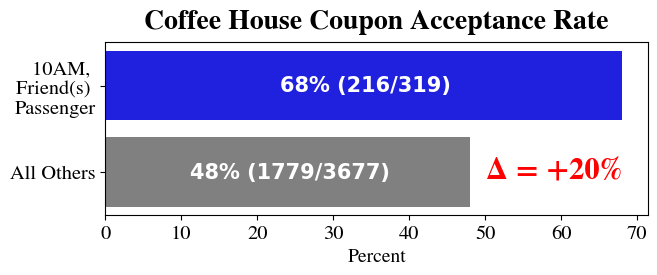

In [278]:
finding2()
plt.savefig("images/coffeehouse_coupon_finding2", bbox_inches='tight')

### **Finding 3.** Friend(s) passenger has around 15% higher acceptance than that of all others  <a name="91"></a>

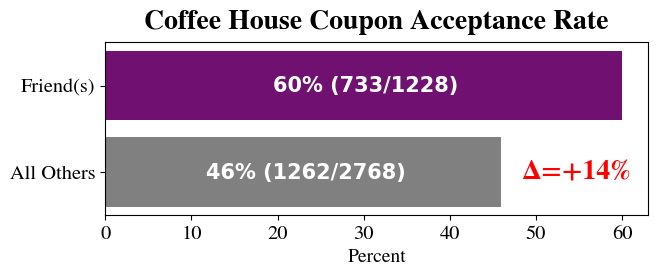

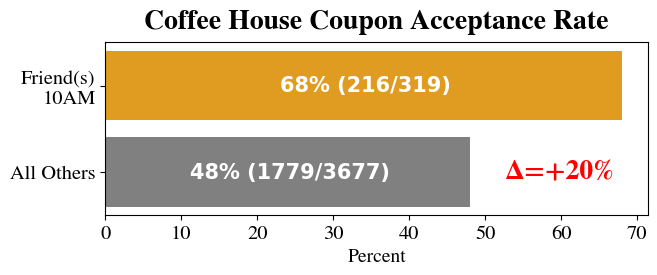

In [279]:
finding3()
plt.savefig("images/coffeehouse_coupon_finding3", bbox_inches='tight')

### **Finding 4.** Expiration of 1 day has around 15% higher acceptance than that of all others <a name="92"></a>

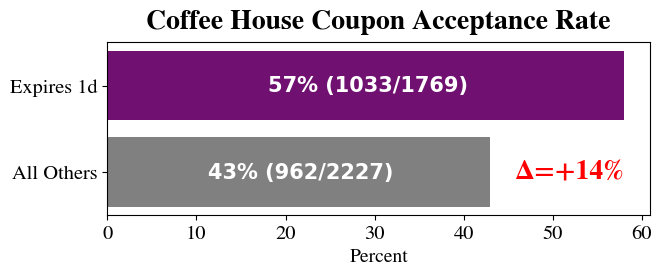

In [280]:
finding4()
plt.savefig("images/coffeehouse_coupon_finding4", bbox_inches='tight')

### **Finding 5.** Drivers that visit the coffee house >=1 time/month have 30% higher acceptance than that of all others. Those that visit 1-3 times/month have 20% higher acceptance rate. <a name="93"></a>

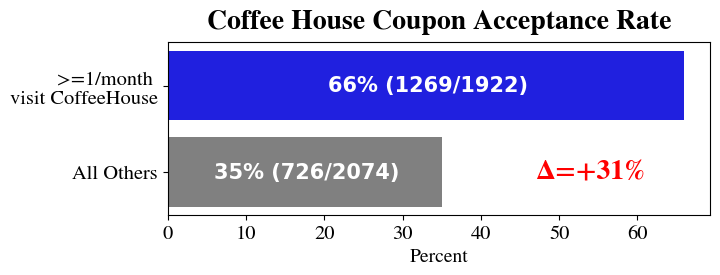

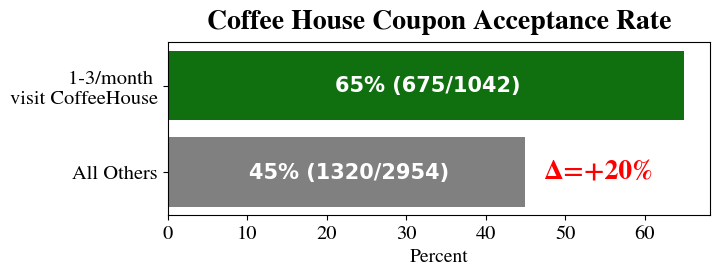

In [275]:
finding5()
plt.savefig("images/coffeehouse_coupon_finding5", bbox_inches='tight')


### **Finding 6.** For students, their coupon acceptance rate is higher if  Coffee House Coupon Location is less than 25 min away or less than 15 min away. <a name="94"></a>

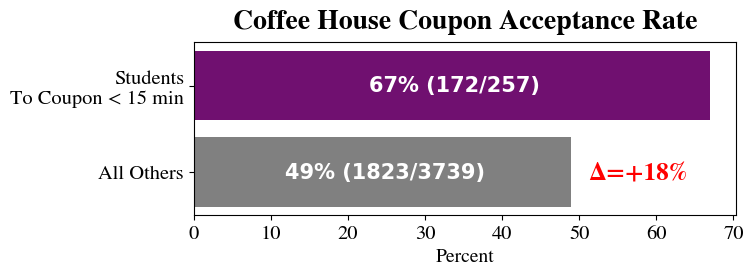

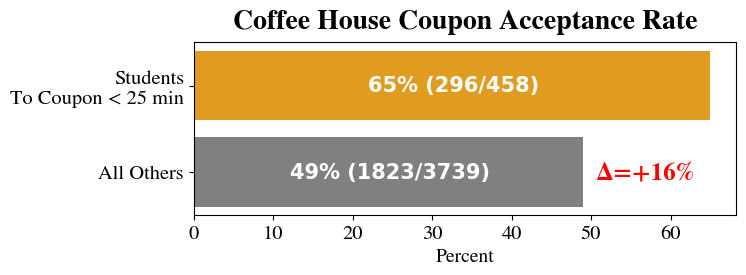

In [276]:
finding6()
plt.savefig("images/coffeehouse_coupon_finding6",bbox_inches='tight')

### Actionable Steps and Recommendations <a name="95"></a>

Based on the conditions where the Coffee House coupon acceptance rate is higher, here are the following recommendations:

* It is advised to focus on focusing on drivers who visit a Coffee House at least once a month or identify regular customers.
* Since the acceptance rate is higher at 10 AM and when passengers are Friend(s), advertisements could be scheduled around that time on holidays and weekends, or times when it is likely to have friend passengers.
* Coffee House advertisements should have an expiration of 1 day or 2 hours.
* To target more students, coupons should be given for coffee shops near by less than 15 min. or 25 min.